In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import pandas as pd
from scipy.io import savemat, loadmat
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
from matplotlib import rc
import numpy as np
import matplotlib
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.pyplot import rc

from tqdm import notebook

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import itertools
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

np.random.seed(42)
import shap

from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.colors as colors
import copy
import matplotlib.gridspec as gridspec

/home/enea/anaconda3/envs/trash2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
# sns.set_theme(style="ticks", palette='twilight_shifted')

In [3]:
info = loadmat('./data/info_age_length_age_ml_v18.mat')
info.keys()
ages = info['ages']
genders = info['genders']
n_days = info['n_days']

ages = ages[n_days >= 7]
genders = genders[n_days >= 7]
n_days = n_days[n_days >= 7]

In [4]:
np.median(n_days)

173.0

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


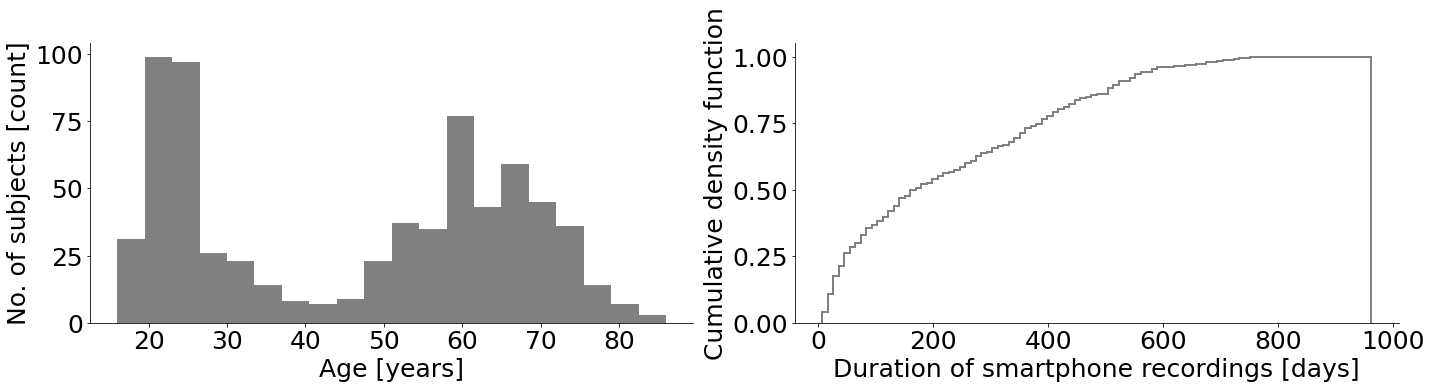

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

## AGE
ax[0].hist(np.squeeze(ages), bins=20, color='grey')

ax[0].set_xlabel("Age [years]")
ax[0].set_ylabel("No. of subjects [count]")
ax[0].grid(False)

## DAYS
n, bins, _ = ax[1].hist(np.squeeze(n_days), 100, density=True, histtype='step',
                           cumulative=True, color='grey', alpha=1.0, linewidth=2)
# ax[1].step(np.cumsum(sorted(full_info["days"])[::-1]), np.cumsum(sorted(full_info["days"])[::-1]) / full_info["days"].sum(), color='grey')
# full_info["days"].hist(bins=20, ax=ax[1], color='grey')

ax[1].set_xlabel("Duration of smartphone recordings [days]")
ax[1].set_ylabel("Cumulative density function")
ax[1].grid(False)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/v18/figure_1_panel_b.pdf', transparent=True)

In [6]:
df_fig1panb = pd.DataFrame(columns={'type', 'N', 'min', 'max', '25th', '50th', '75th'})
df_fig1panb['type'] = ['female', 'age', 'days']
df_fig1panb['N'] = [np.sum(genders == 2), len(ages), len(n_days)]
df_fig1panb['min'] = [np.nan, min(ages), min(n_days)]
df_fig1panb['max'] = [np.nan, max(ages), max(n_days)]
df_fig1panb['25th'] = [np.nan, np.percentile(ages, 25), np.percentile(n_days, 25)]
df_fig1panb['50th'] = [np.nan, np.percentile(ages, 50), np.percentile(n_days, 50)]
df_fig1panb['75th'] = [np.nan, np.percentile(ages, 75), np.percentile(n_days, 75)]
df_fig1panb.to_csv('./figures/v18/figure_1_panel_b.csv', index=False)
df_fig1panb

,50th,type,max,N,75th,25th,min
0,NaN,female,NaN,434,NaN,NaN,NaN
1,52.0,age,86.0,693,64.0,24.0,16.0
2,173.0,days,962.0,693,389.0,52.0,7.0


In [7]:
days_dict = {'180': 0, '90': 1, '60': 2, '30': 3, '10': 4, '5': 5}
new_names = {i:f"{i // 50}-{i % 50}" for i in range(2500)}
new_names[2500] = "gender"
new_names[2501] = "log10(daily count)"
new_names[2502] = "entropy"
new_names[2503] = "screen-size"

In [8]:
Xy_sp = loadmat('./data/ml_age_data_special_full_v18.mat')
X_sp = np.squeeze(Xy_sp['X_all'])
y_sp = np.squeeze(Xy_sp['y_all'])
g_sp = np.squeeze(Xy_sp['g_all'])
u_sp = np.squeeze(Xy_sp['u_all'])
e_sp = np.squeeze(Xy_sp['e_all'])
d_sp = np.squeeze(Xy_sp['d_all'])
n_sp = np.squeeze(Xy_sp['n_all'])
s_sp = np.squeeze(Xy_sp['s_all'])
print((X_sp.shape, y_sp.shape, g_sp.shape, u_sp.shape, e_sp.shape, d_sp.shape, n_sp.shape, s_sp.shape))

((719,), (719,), (719,), (719,), (719,), (719,), (719,), (719,))


In [9]:
D = days_dict['180']
X_180 = np.squeeze(np.array([a[D][0] for a in X_sp if a[D][0].shape[0] > 0]))
y_180 = np.squeeze(np.array([np.int32(a[D][0][0]) for a in y_sp if len(a[D][0][0]) > 0]))
g_180 = np.array([a[D][0][0] for a in g_sp if len(a[D][0][0]) > 0])
u_180 = np.log10(np.array([a[D][0][0] for a in u_sp if len(a[D][0][0]) > 0]) + 1e-15)
e_180 = np.array([a[D][0][0] for a in e_sp if len(a[D][0][0]) > 0])
d_180 = np.array([a[D][0][0] for a in d_sp if len(a[D][0][0]) > 0])
s_180 = np.array([a[D][0][0] for a in s_sp if len(a[D][0][0]) > 0])
X_180.shape, y_180.shape, g_180.shape, s_180.shape

((699, 2500), (699,), (699, 1), (699, 1))

In [10]:
X_180 = np.concatenate([X_180, g_180, u_180, e_180, s_180], axis=1)
X_180.shape, y_180.shape

((699, 2504), (699,))

In [11]:
X_df_180 = pd.DataFrame(X_180)
X_df_180 = X_df_180.rename(columns=new_names)
X_df_180.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-44,49-45,49-46,49-47,49-48,49-49,gender,log10(daily count),entropy,screen-size
0,-3.630571,-3.568730,-3.542383,-3.502066,-3.423630,-3.335741,-3.277073,-3.267057,-3.299257,-3.347322,...,-3.693005,-3.771147,-3.907622,-4.093526,-4.274868,-4.367407,2.0,3.853333,8.542300,6.4
1,-4.216146,-3.980935,-3.836424,-3.618971,-3.246520,-2.845182,-2.494534,-2.209976,-1.996949,-1.864529,...,-4.344569,-4.439114,-4.606612,-4.618576,-4.414060,-4.213787,2.0,4.082067,8.554025,5.8
2,-11.502200,-11.502200,-11.502200,-8.158879,-7.010824,-6.094663,-5.012688,-4.149075,-3.426762,-2.876446,...,-3.021801,-3.086691,-2.955088,-2.741430,-2.602898,-2.548541,2.0,2.158362,9.112261,6.4
3,-3.927504,-4.078349,-4.375328,-4.806324,-5.268090,-5.168265,-4.656739,-4.245199,-3.954151,-3.731596,...,-4.739642,-5.085148,-5.500598,-5.273502,-4.797626,-4.508859,2.0,3.523096,8.665647,5.9
4,-2.560310,-2.574872,-2.654111,-2.802615,-2.993019,-3.165847,-3.313910,-3.481073,-3.614789,-3.517375,...,-4.348234,-4.440028,-4.562347,-4.746822,-5.017296,-5.378845,999.0,2.064458,8.763527,5.0


In [12]:
D = days_dict['90']
X_90 = np.squeeze(np.array([a[D][0] for a in X_sp if a[D][0].shape[0] > 0]))
y_90 = np.squeeze(np.array([np.int32(a[D][0][0]) for a in y_sp if len(a[D][0][0]) > 0]))
g_90 = np.array([a[D][0][0] for a in g_sp if len(a[D][0][0]) > 0])
u_90 = np.log10(np.array([a[D][0][0] for a in u_sp if len(a[D][0][0]) > 0]) + 1e-15)
e_90 = np.array([a[D][0][0] for a in e_sp if len(a[D][0][0]) > 0])
d_90 = np.array([a[D][0][0] for a in d_sp if len(a[D][0][0]) > 0])
s_90 = np.array([a[D][0][0] for a in s_sp if len(a[D][0][0]) > 0])
X_90.shape, y_90.shape, g_90.shape, s_90.shape

X_90 = np.concatenate([X_90, g_90, u_90, e_90, s_90], axis=1)
X_90.shape, y_180.shape

X_df_90 = pd.DataFrame(X_90)
X_df_90 = X_df_90.rename(columns=new_names)
X_df_90.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-44,49-45,49-46,49-47,49-48,49-49,gender,log10(daily count),entropy,screen-size
0,-3.532723,-3.437517,-3.368939,-3.292002,-3.189741,-3.089265,-3.023820,-3.009398,-3.039510,-3.087264,...,-3.631517,-3.727260,-3.904722,-4.182297,-4.487163,-4.516653,2.0,3.916428,8.527164,6.4
1,-4.216049,-3.980837,-3.836326,-3.618874,-3.246423,-2.845084,-2.494436,-2.209878,-1.996851,-1.864432,...,-5.317718,-5.322861,-5.007154,-4.702202,-4.422122,-4.214210,2.0,4.139044,8.552674,5.8
2,-11.502200,-11.502200,-11.502200,-8.158879,-7.010824,-6.094663,-5.012688,-4.149075,-3.426762,-2.876446,...,-3.021801,-3.086691,-2.955088,-2.741430,-2.602898,-2.548541,2.0,2.158362,9.112261,6.4
3,-5.604833,-5.296773,-5.164831,-5.248375,-5.549984,-6.006181,-5.878386,-5.186799,-4.608735,-4.159872,...,-4.530051,-4.869248,-5.426488,-6.204338,-7.203940,-11.502200,2.0,3.522509,8.744188,5.9
4,-2.363482,-2.377363,-2.468314,-2.642316,-2.870299,-3.073977,-3.233389,-3.392747,-3.497347,-3.429001,...,-5.669507,-5.143986,-4.840043,-4.757679,-4.894144,-5.205844,999.0,2.054996,8.799638,5.0


In [13]:
X_df_180 = X_df_180.fillna(0)
X_df_90 = X_df_90.fillna(0)

In [17]:
data_dmatrix = xgb.DMatrix(data=X_df_180.values,label=y_180)

# MAE 1.2 - 6.2 
# params = {"objective":"reg:squarederror", 
#           'colsample_bytree': 0.3,'learning_rate': 0.07, 
#           "tree_method": "gpu_hist", 'max_depth': 3, 'reg_alpha': 0, 'reg_lambda': 0, 'min_split_loss': 0}


# params = {"objective":"reg:squarederror", 
#           'colsample_bytree': .6,'learning_rate': 0.01, 
#            'subsample':1.0, 'max_depth': 5, 'gamma': 0, 
#           'reg_alpha': 0.001, 'reg_lambda': 1, 'min_split_loss': 0.0, 'min_child_weight': 8, 'scale_pos_weight': 1}

# OK - 542
# params = {"objective":"reg:squarederror", 
#           'colsample_bytree': 1.0,'learning_rate': 0.01, 
#            'subsample':1.0, 'max_depth': 8, 'gamma': 0, 
#           'reg_alpha': 0.001, 'reg_lambda': 1, 'min_split_loss': 0.0, 'min_child_weight': 8, 'scale_pos_weight': 1}

# OK maybe final  
params = {"objective":"reg:squarederror", 
          'colsample_bytree': 1,'learning_rate': 0.01, 
           'subsample':1, 'max_depth': 9, 'gamma': 0, 
          'reg_alpha': 0.001, 'reg_lambda': 1, 'min_split_loss': 0.0, 'min_child_weight': 8, 'scale_pos_weight': 1}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=5000, early_stopping_rounds=10, metrics=["mae"], as_pandas=True, seed=123)

In [18]:
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
568,0.458851,0.024246,6.617888,0.576523
569,0.456877,0.024175,6.617914,0.576401
570,0.455006,0.024037,6.617940,0.576296
571,0.453171,0.024200,6.617888,0.576333
572,0.451313,0.024055,6.617821,0.576284


In [15]:
np.random.seed(42)
X_full_180 = X_df_180
Y_full_180 = y_180
X_full_90 = X_df_90
Y_full_90 = y_90
_idx = np.random.permutation(len(X_full_180))
_x, _y = X_full_180.iloc[_idx], Y_full_180[_idx]
print(_x.shape, _y.shape)
data_dmatrix = xgb.DMatrix(data=_x, label=_y)

(699, 2504) (699,)


In [ ]:
param_test1 = {
#  'max_depth':[2, 4, 6, 8],  # 4
#  'min_child_weight': [2, 4, 6, 8]  # 4
    'max_depth':[3, 4, 5],  # 3
    'min_child_weight': [3, 4, 5]  # 3
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=62, max_depth=5,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=1.0,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=1, seed=123), 
 param_grid = param_test1, scoring='r2' ,n_jobs=4, cv=10)
gsearch1.fit(_x, _y)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test3 = {
#  'gamma': [i/10.0 for i in range(0,5)]
    'gamma': [0, 0.001, 0.001, 0.01, 0.1, 1, 10]  # 10
#     'gamma': [10, 50, 100]  # 10
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=62, max_depth=3,
 min_child_weight=5, gamma=0, subsample=1.0, colsample_bytree=1.0,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=1, seed=123), 
 param_grid = param_test3, scoring='r2', n_jobs=4, cv=10)
gsearch3.fit(_x, _y)
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=62, max_depth=3,
 min_child_weight=5, gamma=0, subsample=1.0, colsample_bytree=1.0,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=1, seed=123), 
 param_grid = param_test4, scoring='r2' ,n_jobs=4, cv=10)
gsearch4.fit(_x, _y)
gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test6 = {
 'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=62, max_depth=3,
 min_child_weight=5, gamma=0, subsample=1.0, colsample_bytree=1.0,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=1, seed=123), 
 param_grid = param_test6, scoring='r2' ,n_jobs=4, cv=10)
gsearch6.fit(_x, _y)
gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
#   'reg_lambda': [0.7, 1, 1.2]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=62, max_depth=3,
 min_child_weight=5, gamma=0, subsample=1.0, colsample_bytree=1.0, reg_alpha=0.005,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=1, seed=123), 
 param_grid = param_test7, scoring='r2', n_jobs=4, cv=10)
gsearch7.fit(_x, _y)
gsearch7.best_params_, gsearch7.best_score_

# single model

In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
TH = 7
all_train_pred = []
all_train_true = []
all_test_pred = []
all_test_true = []
all_models = []
train_used = 0

for train_index, test_index in kf.split(_x):
    X_train, X_test = _x.iloc[train_index], _x.iloc[test_index]
    y_train, y_test = _y[train_index], _y[test_index]
#     print(X_train.shape, X_test.shape)
    d_train, d_test = np.squeeze(d_180[train_index]), np.squeeze(d_180[test_index])
    
    X_train = X_train[d_train >= TH]
    y_train = y_train[d_train >= TH]
    train_used += np.sum(d_train >= TH)
    print(f"TR {np.sum(d_train >= TH) / len(d_train) * 100:.2f}%")
    
    model = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params).fit(X_train, y_train)
    all_models.append(model)
    pred_vals_train = model.predict(X_train)
    pred_vals_test = model.predict(X_test)
    
    all_train_pred.extend(pred_vals_train)
    all_test_pred.extend(pred_vals_test)
    all_train_true.extend(y_train)
    all_test_true.extend(y_test)
    print(f"TR : {mean_absolute_error(np.array(all_train_true), np.array(all_train_pred)):.2f} - TE : {mean_absolute_error(np.array(all_test_true), np.array(all_test_pred)):.2f}")

TR 97.77%
TR : 0.44 - TE : 6.92
TR 97.93%
TR : 0.46 - TE : 6.87
TR 98.41%
TR : 0.45 - TE : 6.51
TR 97.77%
TR : 0.44 - TE : 6.73
TR 97.77%
TR : 0.44 - TE : 6.63
TR 98.09%
TR : 0.45 - TE : 6.64
TR 97.93%
TR : 0.45 - TE : 6.69
TR 98.25%
TR : 0.45 - TE : 6.54
TR 97.93%
TR : 0.45 - TE : 6.63
TR 98.10%
TR : 0.46 - TE : 6.55


In [20]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
TH = 7
all_train_pred_90 = []
all_train_true_90 = []
all_test_pred_90 = []
all_test_true_90 = []
all_models_90 = []
train_used = 0

for train_index, test_index in kf.split(X_full_90):
#     print("TRAIN:", train_index[:3], "TEST:", test_index[:3])
    X_train, X_test = X_full_90.iloc[train_index], X_full_90.iloc[test_index]
    y_train, y_test = Y_full_90[train_index], Y_full_90[test_index]
#     print(X_train.shape, X_test.shape)
    d_train, d_test = np.squeeze(d_90[train_index]), np.squeeze(d_90[test_index])
    
    X_train = X_train[d_train >= TH]
    y_train = y_train[d_train >= TH]
    train_used += np.sum(d_train >= TH)
    print(f"TR {np.sum(d_train >= TH) / len(d_train) * 100:.2f}%")
    
    model = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params).fit(X_train, y_train)
    all_models_90.append(model)
    pred_vals_train = model.predict(X_train)
    pred_vals_test = model.predict(X_test)
    
    all_train_pred_90.extend(pred_vals_train)
    all_test_pred_90.extend(pred_vals_test)
    all_train_true_90.extend(y_train)
    all_test_true_90.extend(y_test)
    print(f"TR : {np.mean(np.abs(np.array(all_train_pred_90) - np.array(all_train_true_90))):.2f} - TE : {np.mean(np.abs(np.array(all_test_pred_90) - np.array(all_test_true_90))):.2f}")

TR 97.62%
TR : 0.42 - TE : 5.91
TR 97.77%
TR : 0.45 - TE : 6.21
TR 98.25%
TR : 0.45 - TE : 6.26
TR 97.62%
TR : 0.45 - TE : 6.43
TR 97.62%
TR : 0.46 - TE : 6.57
TR 97.93%
TR : 0.45 - TE : 6.33
TR 97.77%
TR : 0.45 - TE : 6.42
TR 98.09%
TR : 0.46 - TE : 6.37
TR 97.77%
TR : 0.46 - TE : 6.37
TR 98.10%
TR : 0.45 - TE : 6.58


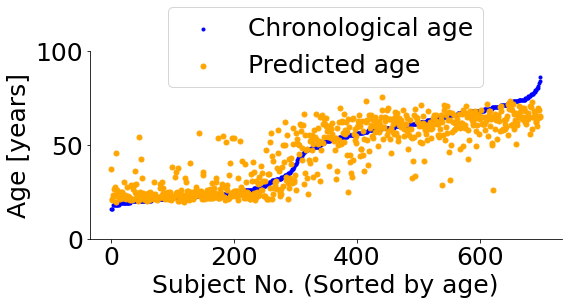

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.6))

pred_vals = np.array(all_test_pred)
real_vals = np.array(all_test_true)

s_idx = np.argsort(real_vals)
ax.scatter(np.arange(len(s_idx)),real_vals[s_idx], marker='.', c='b', label='Chronological age')  
ax.scatter(np.arange(len(s_idx)), pred_vals[s_idx], marker='.', s=100, c='orange', label='Predicted age')  
ax.grid(False)
ax.legend(loc='upper center',  ncol=1, bbox_to_anchor=[.5, 1.3])

ax.set_ylabel('Age [years]')
ax.set_xlabel('Subject No. (Sorted by age)');
ax.set_ylim([0, 100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('figures/v18/figure_1_panel_c.pdf')

In [224]:
mean_absolute_error(np.array(all_train_true_90), np.array(all_train_pred_90))

0.46423249774509007

### explain

In [306]:
all_shap = []
all_test = []
for i, (train_index, test_index) in enumerate(kf.split(X_df_180)):
    _, X_test = X_df_180.iloc[train_index], X_df_180.iloc[test_index]
    _, y_test = y_180[train_index], y_180[test_index]
    explainer = shap.Explainer(all_models[i])
    shap_values = explainer(X_test)
    all_shap.extend(shap_values)
    all_test.extend(y_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


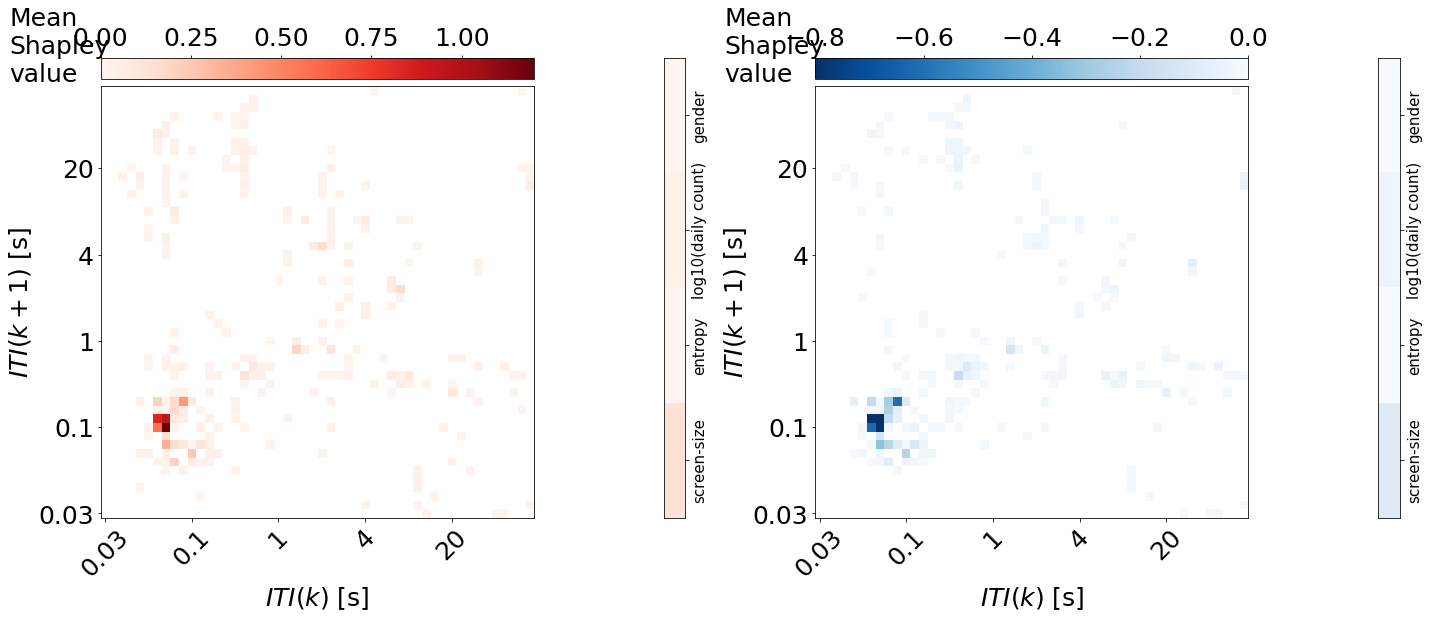

In [395]:
fig = plt.figure(figsize=(20, 8.7))
gs0 = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 0.05, 1, 0.05])

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

shap_values = all_shap
pos_val = np.zeros((len(shap_values), 50, 50)) * np.nan
neg_val = np.zeros((len(shap_values), 50, 50)) * np.nan
pos_extra = np.zeros((len(shap_values), 4)) * np.nan
neg_extra = np.zeros((len(shap_values), 4)) * np.nan
for IDX in range(len(shap_values)):
    _pos = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _neg = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _pos_e = copy.deepcopy(shap_values[IDX].values[2500:])
    _neg_e = copy.deepcopy(shap_values[IDX].values[2500:])
    
    _pos[_pos < 0] = 0
    pos_val[IDX] = _pos
    _pos_e[_pos_e < 0] = 0
    pos_extra[IDX] = _pos_e
    
    _neg[_neg > 0] = 0
    neg_val[IDX] = _neg
    _neg_e[_neg_e > 0] = 0
    neg_extra[IDX] = _neg_e

    
m_pos = np.nanmean(pos_val, 0)
mask = np.ones_like(m_pos)
mask[m_pos < 0.01] = np.nan
ax0 = fig.add_subplot(gs0[0, 0])
im = ax0.imshow(m_pos * mask, cmap='Reds', vmax=1.2, vmin=0, aspect='auto')
ax0.invert_yaxis()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels)
ax0.xaxis.set_tick_params(rotation=45)
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)
ax0.set_ylabel(r'$ITI(k + 1)$ [s]')
ax0.set_xlabel(r'$ITI(k)$ [s]')
ax0.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)
    
    
ax01 = fig.add_subplot(gs0[0, 1])
ax01.imshow(np.nanmean(pos_extra, 0)[:, None], vmax=1.2, vmin=0, cmap='Reds', aspect='auto')
ax01.yaxis.tick_right()
ax01.set_xticks([])
ax01.set_yticks([0, 1, 2, 3])
ax01.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90, size=15, verticalalignment='center')

# ax99 = fig.add_subplot(gs0[0, 2])
# ax99.set_xticks([])
# ax99.set_yticks([])
# ax99.spines['right'].set_visible(False)
# ax99.spines['top'].set_visible(False)
# ax99.spines['left'].set_visible(False)
# ax99.spines['bottom'].set_visible(False)

m_neg = np.nanmean(neg_val, 0)
mask = np.ones_like(m_neg)
mask[m_neg > -0.01] = np.nan
ax1 = fig.add_subplot(gs0[0, 2])
im = ax1.imshow(m_neg * mask, cmap="Blues_r", vmin=-0.8, vmax=0, aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax1.invert_yaxis()
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_yticks(ticks)
ax1.set_yticklabels(labels)
ax1.set_ylabel(r'$ITI(k + 1)$ [s]')
ax1.set_xlabel(r'$ITI(k)$ [s]')
ax1.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)

ax11 = fig.add_subplot(gs0[0, 3])
ax11.imshow(np.nanmean(neg_extra, 0)[:, None], vmin=-0.8, vmax=0, cmap='Blues_r', aspect='auto')
ax11.yaxis.tick_right()
ax11.set_xticks([])
ax11.set_yticks([0, 1, 2, 3])
ax11.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90, size=15, verticalalignment='center')

plt.tight_layout()
plt.savefig("figures/v18/figure_1_panel_e.pdf")

## time test

In [387]:
kf = KFold(n_splits=10, shuffle=True)
TH = 1
all_test_pred = []
all_test_true = []
all_regr_sp = []
all_train_pred = []
all_train_true = []

for train_index, test_index in kf.split(X_sp):
    X_train = X_sp[train_index]
    y_train = y_sp[train_index]
    X_test = X_sp[test_index]
    y_test = y_sp[test_index]
    g_train = g_sp[train_index]
    g_test = g_sp[test_index]
    u_train = u_sp[train_index]
    u_test = u_sp[test_index]
    e_train = e_sp[train_index]
    e_test = e_sp[test_index]
    d_train = d_sp[train_index]
    d_test = d_sp[test_index]
    s_train = s_sp[train_index]
    s_test = s_sp[test_index]
    
    D = days_dict['180']
    X_d = np.squeeze(np.array([a[D][0] for a in X_train if a[D][0].shape[0] > 0]))
    y_tr = np.squeeze(np.array([a[D][0][0] for a in y_train if len(a[D][0][0]) > 0]))
    g_d = np.array([a[D][0][0] for a in g_train if len(a[D][0][0]) > 0])
    u_d = np.log10(np.array([a[D][0][0] for a in u_train if len(a[D][0][0]) > 0]) + 1e-15)
    e_d = np.array([a[D][0][0] for a in e_train if len(a[D][0][0]) > 0])
    d_d = np.squeeze(np.array([a[D][0][0] for a in d_train if len(a[D][0][0]) > 0]))
    s_d = np.array([a[D][0][0] for a in s_train if len(a[D][0][0]) > 0])
    X_d = np.concatenate([X_d, g_d, u_d, e_d, s_d], axis=1)
    
    X_d = X_d[d_d >= TH]
    y_tr = y_tr[d_d >= TH]
    train_used += np.sum(d_d >= TH)
    print(f"TR {np.sum(d_d >= TH) / len(d_d) * 100:.2f}%")
    
    X_df_train = pd.DataFrame(X_d)
    X_df_train = X_df_train.rename(columns=new_names)
    
    X_d = np.squeeze(np.array([a[D][0] for a in X_test if a[D][0].shape[0] > 0]))
    y_te = np.squeeze(np.array([a[D][0][0] for a in y_test if len(a[D][0][0]) > 0]))
    g_d = np.array([a[D][0][0] for a in g_test if len(a[D][0][0]) > 0])
    u_d = np.log10(np.array([a[D][0][0] for a in u_test if len(a[D][0][0]) > 0]) + 1e-15)
    e_d = np.array([a[D][0][0] for a in e_test if len(a[D][0][0]) > 0])
    d_d = np.array([a[D][0][0] for a in d_test if len(a[D][0][0]) > 0])
    s_d = np.array([a[D][0][0] for a in s_test if len(a[D][0][0]) > 0])
    X_d = np.concatenate([X_d, g_d, u_d, e_d, s_d], axis=1)
    X_df_test = pd.DataFrame(X_d)
    X_df_test = X_df_test.rename(columns=new_names)

    model = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params).fit(X_df_train, y_tr)
    all_regr_sp.append(model)
    pred_vals_train = model.predict(X_df_train)
    pred_vals_test = model.predict(X_df_test)
    
    all_train_pred.extend(pred_vals_train)
    all_train_true.extend(y_tr)
    
    to_append_pred_test = [pred_vals_test]
    to_append_true_test = [y_te]
    
    for _days in ['90', '60', '30', '10', '5']:
        D = days_dict[_days]
        X_d = np.squeeze(np.array([a[D][0] for a in X_test if a[D][0].shape[0] > 0]))
        y_d = np.squeeze(np.array([a[D][0][0] for a in y_test if len(a[D][0][0]) > 0]))
        g_d = np.array([a[D][0][0] for a in g_test if len(a[D][0][0]) > 0])
        u_d = np.log10(np.array([a[D][0][0] for a in u_test if len(a[D][0][0]) > 0]) + 1e-15)
        e_d = np.array([a[D][0][0] for a in e_test if len(a[D][0][0]) > 0])
        d_d = np.array([a[D][0][0] for a in d_test if len(a[D][0][0]) > 0])
        s_d = np.array([a[D][0][0] for a in s_test if len(a[D][0][0]) > 0])
        X_d = np.concatenate([X_d, g_d, u_d, e_d, s_d], axis=1)
        X_df_d = pd.DataFrame(X_d)
        X_df_d = X_df_d.rename(columns=new_names)
        pred_vals_d = model.predict(X_df_d)
        
        to_append_pred_test.append(pred_vals_d)
        to_append_true_test.append(y_d)
        
    all_test_pred.append(to_append_pred_test)
    all_test_true.append(to_append_true_test)

TR 99.21%
TR 99.21%
TR 99.36%
TR 99.37%
TR 99.21%
TR 99.36%
TR 99.20%
TR 99.52%
TR 99.21%
TR 99.20%


In [388]:
errors_mae = [[] for _ in range(6)]
errors = [[] for _ in range(6)]
all_r2_pred = [[] for _ in range(6)]
all_r2_true = [[] for _ in range(6)]

for days in range(6):
    for fold in range(10):
        errors_mae[days].extend(np.abs(all_test_pred[fold][days] - all_test_true[fold][days]))
        errors[days].extend(all_test_pred[fold][days] - all_test_true[fold][days])
        all_r2_pred[days].extend(all_test_pred[fold][days])
        all_r2_true[days].extend(all_test_true[fold][days])

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


,75th,MAE,days,R2,25th,mean,50th,N
0,3.652359,7.255285,5,0.756093,-6.855524,-1.282916,-0.545734,675
1,3.529867,6.970386,10,0.776314,-6.944287,-1.220278,-0.742412,688
2,4.095203,6.670779,30,0.789358,-5.640056,-0.580991,-0.014079,698
3,4.132426,6.539367,60,0.795819,-5.245635,-0.476605,-0.118660,699
4,3.978775,6.404590,90,0.797588,-4.645650,-0.396257,-0.012227,699
5,3.927370,6.380306,180,0.797701,-4.995858,-0.535168,-0.012244,699


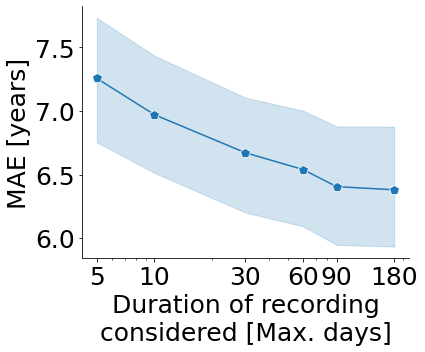

In [389]:
a = pd.concat([pd.DataFrame({"error": errors[i], "error_mae": errors_mae[i], "days": np.ones(len(errors[i])) * d}) for i, d in enumerate([180, 90, 60, 30, 10, 5])], 0)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=a.reset_index(drop=True), x='days', y='error_mae', ax=ax, marker='p', markersize=10)
ax.grid(False)
ax.set_xlabel("Duration of recording\nconsidered [Max. days]")
ax.set_ylabel("MAE [years]")
ax.set(xscale="log")
ax.set_xticks([5, 10, 30, 60, 90, 180]);
ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('figures/v18/figure_1_panel_d.pdf')

df_fig1pand = pd.DataFrame(columns={'N', '25th', '50th', '75th', 'mean', 'MAE', 'R2', 'days'})
df_fig1pand['days'] = ['5', '10', '30', '60', '90', '180']
df_fig1pand['N'] = [len(a[a['days'] == 5]['error']), 
                    len(a[a['days'] == 10]['error']), 
                    len(a[a['days'] == 30]['error']),
                    len(a[a['days'] == 60]['error']), 
                    len(a[a['days'] == 90]['error']), 
                    len(a[a['days'] == 180]['error'])]

df_fig1pand['25th'] = [np.percentile(a[a['days'] == 5]['error'], 25), 
                       np.percentile(a[a['days'] == 10]['error'], 25), 
                       np.percentile(a[a['days'] == 30]['error'], 25), 
                       np.percentile(a[a['days'] == 60]['error'], 25), 
                       np.percentile(a[a['days'] == 90]['error'], 25), 
                       np.percentile(a[a['days'] == 180]['error'], 25)]

df_fig1pand['50th'] = [np.percentile(a[a['days'] == 5]['error'], 50), 
                       np.percentile(a[a['days'] == 10]['error'], 50), 
                       np.percentile(a[a['days'] == 30]['error'], 50), 
                       np.percentile(a[a['days'] == 60]['error'], 50), 
                       np.percentile(a[a['days'] == 90]['error'], 50), 
                       np.percentile(a[a['days'] == 180]['error'], 50)]

df_fig1pand['75th'] = [np.percentile(a[a['days'] == 5]['error'], 75), 
                       np.percentile(a[a['days'] == 10]['error'], 75), 
                       np.percentile(a[a['days'] == 30]['error'], 75), 
                       np.percentile(a[a['days'] == 60]['error'], 75), 
                       np.percentile(a[a['days'] == 90]['error'], 75), 
                       np.percentile(a[a['days'] == 180]['error'], 75)]

df_fig1pand['mean'] = [np.mean(a[a['days'] == 5]['error']), 
                       np.mean(a[a['days'] == 10]['error']), 
                       np.mean(a[a['days'] == 30]['error']), 
                       np.mean(a[a['days'] == 60]['error']), 
                       np.mean(a[a['days'] == 90]['error']), 
                       np.mean(a[a['days'] == 180]['error'])]

df_fig1pand['MAE'] = [np.mean(a[a['days'] == 5]['error'].abs()), 
                      np.mean(a[a['days'] == 10]['error'].abs()), 
                      np.mean(a[a['days'] == 30]['error'].abs()), 
                      np.mean(a[a['days'] == 60]['error'].abs()), 
                      np.mean(a[a['days'] == 90]['error'].abs()), 
                      np.mean(a[a['days'] == 180]['error'].abs())]

df_fig1pand['R2'] = [r2_score(all_r2_true[5], all_r2_pred[5]), 
                      r2_score(all_r2_true[4], all_r2_pred[4]),
                      r2_score(all_r2_true[3], all_r2_pred[3]),
                      r2_score(all_r2_true[2], all_r2_pred[2]),
                      r2_score(all_r2_true[1], all_r2_pred[1]),
                      r2_score(all_r2_true[0], all_r2_pred[0]),
                     ]

df_fig1pand.to_csv('figures/v18/figure_1_panel_d.csv', index=False)
df_fig1pand

# Stroke

In [21]:
Xy_stroke_all = loadmat('./data/ml_age_STROKE_data_v18.mat')
X_stroke_all = np.squeeze(Xy_stroke_all['X_all'])
y_stroke_all = np.squeeze(Xy_stroke_all['y_all'])
g_stroke_all = np.squeeze(Xy_stroke_all['g_all'])
u_stroke_all = np.squeeze(Xy_stroke_all['u_all'])
e_stroke_all = np.squeeze(Xy_stroke_all['e_all'])
s_stroke_all = np.squeeze(Xy_stroke_all['s_all'])
print((X_stroke_all.shape, y_stroke_all.shape, g_stroke_all.shape, u_stroke_all.shape, e_stroke_all.shape, s_stroke_all.shape))


((41,), (41,), (41,), (41,), (41,), (41,))


In [22]:
X_stroke_test = X_stroke_all[:]
y_stroke_test = y_stroke_all[:]
g_stroke_test = g_stroke_all[:]
u_stroke_test = u_stroke_all[:]
e_stroke_test = e_stroke_all[:]
s_stroke_test = s_stroke_all[:]

# only first
X_stroke_sub_test = np.array([a[:, 0] for a in X_stroke_test])
y_stroke_sub_test = np.squeeze(np.array([np.int32(a[0]) for a in y_stroke_test]))
g_stroke_sub_test = np.array([a[0] for a in g_stroke_test]) * 1
u_stroke_sub_test = np.log10(np.array([a[0] for a in u_stroke_test]) + 1e-15) * 1
e_stroke_sub_test = np.array([a[0] for a in e_stroke_test]) * 1
s_stroke_sub_test = np.array([a[0] for a in s_stroke_test])


# put tog.
X_stroke_test = np.concatenate([X_stroke_sub_test[:, :], g_stroke_sub_test, u_stroke_sub_test, e_stroke_sub_test, s_stroke_sub_test], -1)
print(X_stroke_test.shape)

(41, 2504)


In [23]:
X_s_df = pd.DataFrame(X_stroke_test)
X_s_df = X_s_df.rename(columns=new_names)
X_s_df.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-44,49-45,49-46,49-47,49-48,49-49,gender,log10(daily count),entropy,screen-size
0,-4.373427,-3.951597,-3.622396,-3.423923,-3.292385,-3.211605,-3.217920,-3.311628,-3.421820,-3.454728,...,-2.930794,-2.887404,-2.781564,-2.759139,-2.849367,-2.988448,1.0,3.126618,8.805649,6.41
1,-2.707356,-2.721654,-2.765770,-2.793381,-2.792464,-2.819509,-2.884623,-2.915082,-2.857379,-2.767205,...,-3.994684,-4.177075,-4.176012,-3.974117,-3.779640,-3.661724,2.0,3.304921,8.535331,6.70
2,-3.557439,-3.687632,-3.448302,-3.117783,-2.931937,-2.932132,-3.111492,-3.391282,-3.526403,-3.463159,...,-5.834419,-6.299233,-6.962576,-7.530051,-7.210234,-6.856004,1.0,2.635484,8.349299,5.00
3,-3.965393,-3.921730,-3.952250,-4.082123,-4.353072,-4.800103,-5.329249,-5.171379,-4.692967,-4.394706,...,-3.666588,-3.638786,-3.582993,-3.559017,-3.613560,-3.704745,2.0,3.611829,8.657956,5.10
4,-2.973198,-2.931336,-2.963576,-3.064181,-3.134579,-3.086783,-3.039282,-3.092241,-3.256223,-3.506194,...,-3.870860,-3.991201,-3.938359,-3.937860,-4.061359,-4.304795,2.0,3.005395,8.584651,4.70


In [24]:
all_pred_stroke_ages = []

for _model in all_models_90:
    pred_vals_test_s = _model.predict(X_s_df)
    all_pred_stroke_ages.append(pred_vals_test_s)

In [25]:
all_pred_zeros = [np.int32(a.predict(X_s_df * 0)[0]) for a in all_models_90]
print(all_pred_zeros)

[48, 37, 37, 47, 40, 40, 46, 39, 47, 52]


In [26]:
stacked_stroke = np.vstack(all_pred_stroke_ages)
min_s_stroke = np.percentile(stacked_stroke, 2.5, 0)
max_s_stroke = np.percentile(stacked_stroke, 97.5, 0)
med_s_stroke = np.percentile(stacked_stroke, 50, 0)

In [27]:
error_90 = np.array(all_test_true_90) - np.array(all_test_pred_90)
chained_real = np.array(all_test_true_90)
chained_90 = np.array(all_test_pred_90)
all_real_90 = np.array(all_test_true_90)
all_pred_90 = np.array(all_test_pred_90)

In [28]:
# subsample based on stroke distribution
nboot = 10000
subsets_true = []
subsets_pred = []
for _ in range(nboot):
    to_add_true = []
    to_add_pred = []
    for x in y_stroke_sub_test:
        _true_matched = chained_real[chained_real == x]
        _pred_matched = chained_90[chained_real == x]
        if len(_true_matched) == 0:  # if I don't have 83 I try with 84 anyway is close enough to match the distro
            _true_matched = chained_real[chained_real == x + 1]
            _pred_matched = error_90[chained_real == x + 1]
        _idx = np.random.choice(len(_true_matched))
        to_add_true.append(_true_matched[_idx])
        to_add_pred.append(_pred_matched[_idx])
    subsets_pred.append(np.array(to_add_pred))
    subsets_true.append(np.array(to_add_true))

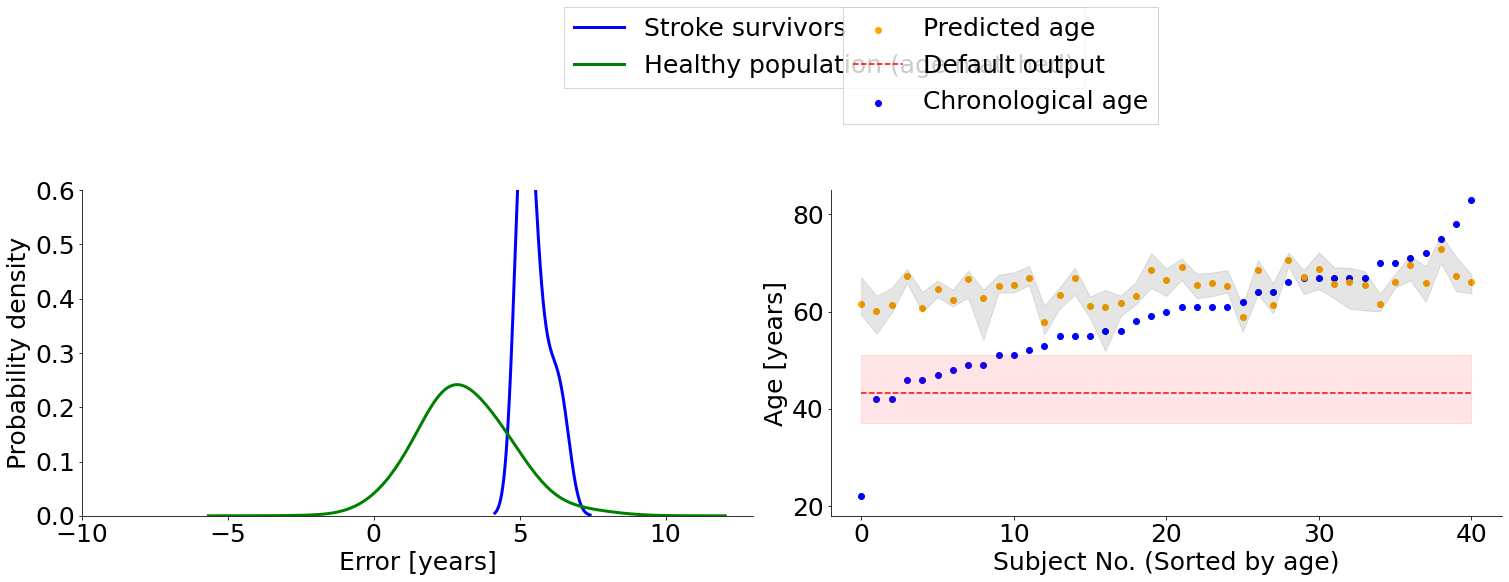

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))

idx = np.argsort(y_stroke_sub_test)

ss = np.linspace(-0.0, 40, 41)

ax[1].fill_between(ss, min_s_stroke[idx], max_s_stroke[idx], color='k', alpha=0.1, zorder=3)
ax[1].scatter(np.arange(len(idx)), y_stroke_sub_test[idx], marker='o', color='blue', label='Chronological age')
ax[1].scatter(np.arange(len(idx)), med_s_stroke[idx], marker='o', c='orange', label='Predicted age')
ax[1].set_xlabel('Subject No. (Sorted by age)')
ax[1].set_ylabel('Age [years]')
# ax[1].plot([0, 40], [np.mean(ages), np.mean(ages)], 'k--', alpha=1.0, label='Mean age (healthy training set)')
ax[1].plot([0, 40], [np.mean(all_pred_zeros), np.mean(all_pred_zeros)], 'r--', alpha=1.0, label='Default output')
ax[1].fill_between(ss, np.percentile(all_pred_zeros, 2.5), np.percentile(all_pred_zeros, 97.5), color='r', alpha=0.1, zorder=3)

handles, labels = ax[1].get_legend_handles_labels()
order = [1, 2, 0]
ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[0.0, 1.6])

ax[1].grid(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylim([18, 85])
X = np.array([np.median(a - y_stroke_sub_test) for a in all_pred_stroke_ages])
# X = list(itertools.chain.from_iterable([a - y_stroke_sub_test for a in all_pred_stroke_ages]))
# ax[0].hist(X)
sns.kdeplot(X, ax=ax[0], bw_method=.6, linewidth=3, label='Stroke survivors', color='blue')
Y = [np.median(a - b) for a, b in zip(subsets_true, subsets_pred)]
# Y = list(itertools.chain.from_iterable([a - b for a, b in zip(subsets_true, subsets_pred)]))
sns.kdeplot(Y, ax=ax[0], bw_method=.6, linewidth=3, label='Healthy population (age matched)', color='g')
# ax[0].hist(Y, color='g')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend(shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[.7, 1.6])
ax[0].set_xlabel("Error [years]")
ax[0].set_ylabel("Probability density")
ax[0].grid(False)
ax[0].set_xlim([-10, 13])
ax[0].set_ylim([0, 0.6])

plt.tight_layout()

# plt.savefig('./figures/v18/figure_2_panel_d_stroke.pdf')

In [30]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(X, Y)

df_fig2_stroke = pd.DataFrame({'type': ['stroke distro', 'healthy distro', 't-test'], 
                        'p-val': [np.nan, np.nan, pval],
                        't-val': [np.nan, np.nan, tval], 
                        '25th': [np.percentile(X, 25),np.percentile(Y, 25), np.nan],
                        '50th': [np.percentile(X, 50),np.percentile(Y, 50), np.nan],
                        '75th': [np.percentile(X, 75),np.percentile(Y, 75), np.nan],
                        'mean': [np.mean(X),np.mean(Y), np.nan],
                        'MAE': [np.mean(np.abs(y_stroke_sub_test - med_s_stroke)),np.nan, np.nan]
                           })
df_fig2_stroke.to_csv('./figures/v18/fig2_stroke_stats.csv')
df_fig2_stroke

,type,p-val,t-val,25th,50th,75th,mean,MAE
0,stroke distro,NaN,NaN,5.098580,5.325649,5.723086,5.494168,9.160104
1,healthy distro,NaN,NaN,2.179508,2.831852,3.962646,3.115422,NaN
2,t-test,3.886387e-07,5.077833,NaN,NaN,NaN,NaN,NaN


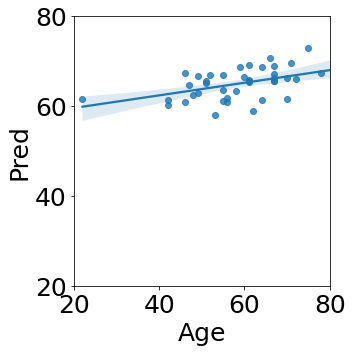

In [36]:
df_ = pd.DataFrame({'Age': y_stroke_sub_test[idx], 'Pred' : med_s_stroke[idx]})
fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.regplot(y="Pred", x="Age", data=df_);
ax.set_xlabel('Age')
ax.set_ylabel('Pred');
ax.set_xlim([20, 80])
ax.set_ylim([20, 80])
plt.tight_layout()
plt.grid(False)
plt.savefig('./figures/v18/figure_2_insert_stroke_v2.pdf')
savemat('./data/figure_2_xgboost_insert_stroke.mat', {'real_str': y_stroke_sub_test[idx], 'pred_str': med_s_stroke[idx]})

# EPI

In [37]:
Xy_rns_all = loadmat('./data/ml_age_RNS_data_v18.mat')
X_rns_all = np.squeeze(Xy_rns_all['X_all'])
y_rns_all = np.squeeze(Xy_rns_all['y_all'])
g_rns_all = np.squeeze(Xy_rns_all['g_all'])
u_rns_all = np.squeeze(Xy_rns_all['u_all'])
e_rns_all = np.squeeze(Xy_rns_all['e_all'])
s_rns_all = np.squeeze(Xy_rns_all['s_all'])
partId_rns_all = np.squeeze(Xy_rns_all['partId_all'])
print((X_rns_all.shape, y_rns_all.shape, g_rns_all.shape, u_rns_all.shape, e_rns_all.shape, s_rns_all.shape, partId_rns_all.shape))

((8,), (8,), (8,), (8,), (8,), (8,), (8,))


In [38]:
X_rns_test = X_rns_all[:]
y_rns_test = y_rns_all[:]
g_rns_test = g_rns_all[:]
u_rns_test = u_rns_all[:]
e_rns_test = e_rns_all[:]
s_rns_test = s_rns_all[:]

# only first
X_rns_sub_test = np.array([a[:, 0] for a in X_rns_test])
y_rns_sub_test = np.squeeze(np.array([np.int32(a[0]) for a in y_rns_test]))
g_rns_sub_test = np.array([a[0] for a in g_rns_test]) * 1
u_rns_sub_test = np.log10(np.array([a[0] for a in u_rns_test]) + 1e-15) * 1
e_rns_sub_test = np.array([a[0] for a in e_rns_test]) * 1
s_rns_sub_test = np.array([a[0] for a in s_rns_test]) * 1


# put tog.
X_rns_test = np.concatenate([X_rns_sub_test[:, :], g_rns_sub_test, u_rns_sub_test, e_rns_sub_test, s_rns_sub_test], -1)
print(X_rns_test.shape)

(8, 2504)


In [39]:
X_r_df = pd.DataFrame(X_rns_test)
X_r_df = X_r_df.rename(columns=new_names)
X_r_df.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-44,49-45,49-46,49-47,49-48,49-49,gender,log10(daily count),entropy,screen-size
0,-0.997272,-0.982039,-0.977887,-0.974541,-0.971803,-0.971106,-0.970548,-0.972909,-0.986478,-1.014487,...,-3.330367,-3.347659,-3.417655,-3.565274,-3.772753,-3.964452,2.0,2.957128,8.243252,5.8
1,-1.880153,-1.896382,-1.943424,-1.989961,-2.027763,-2.069922,-2.125519,-2.193184,-2.266056,-2.341363,...,-2.293705,-2.259519,-2.256219,-2.265581,-2.260522,-2.241470,2.0,3.348694,8.421973,5.8
2,-1.422073,-1.460459,-1.672639,-1.926707,-2.025023,-2.067455,-2.182906,-2.307060,-2.349502,-2.372391,...,-4.818880,-4.762621,-4.906317,-5.236973,-5.568977,-5.256282,1.0,2.606381,8.430714,5.0
3,-3.082259,-3.059294,-3.058307,-3.068739,-3.063792,-3.043392,-3.030733,-3.034397,-3.055414,-3.097500,...,-3.143146,-3.154749,-3.135080,-3.068371,-2.999405,-2.970416,1.0,3.494433,8.791090,5.1
4,-2.220038,-2.246118,-2.282974,-2.327247,-2.354304,-2.363925,-2.382937,-2.419782,-2.473893,-2.552743,...,-2.799203,-2.787617,-2.802763,-2.851213,-2.916925,-2.956989,2.0,2.780677,8.894790,NaN


In [40]:
all_pred_rns_ages = [a.predict(X_r_df) for a in all_models]

In [41]:
Xy_epi_all = loadmat('ml_age_epi_data_v18.mat')
X_epi_all = np.squeeze(Xy_epi_all['X_all'])
y_epi_all = np.squeeze(Xy_epi_all['y_all'])
g_epi_all = np.squeeze(Xy_epi_all['g_all'])
u_epi_all = np.squeeze(Xy_epi_all['u_all'])
e_epi_all = np.squeeze(Xy_epi_all['e_all'])
s_epi_all = np.squeeze(Xy_epi_all['s_all'])
partId_epi_all = np.squeeze(Xy_epi_all['partId_all'])
print((X_epi_all.shape, y_epi_all.shape, g_epi_all.shape, u_epi_all.shape, e_epi_all.shape, s_epi_all.shape, partId_epi_all.shape))


((43,), (43,), (43,), (43,), (43,), (43,), (43,))


In [42]:
X_epi_test = X_epi_all[:]
y_epi_test = y_epi_all[:]
g_epi_test = g_epi_all[:]
u_epi_test = u_epi_all[:]
e_epi_test = e_epi_all[:]
s_epi_test = s_epi_all[:]

# only first
X_epi_sub_test = np.array([a[:, 0] for a in X_epi_test])
y_epi_sub_test = np.squeeze(np.array([np.int32(a[0]) for a in y_epi_test]))
g_epi_sub_test = np.array([a[0] for a in g_epi_test]) * 1
u_epi_sub_test = np.log10(np.array([a[0] for a in u_epi_test]) + 1e-15) * 1
e_epi_sub_test = np.array([a[0] for a in e_epi_test]) * 1
s_epi_sub_test = np.array([a[0] for a in s_epi_test]) * 1


# put tog.
X_epi_test = np.concatenate([X_epi_sub_test[:, :], g_epi_sub_test, u_epi_sub_test, e_epi_sub_test, s_epi_sub_test], -1)
print(X_epi_test.shape)

(43, 2504)


In [43]:
X_e_df = pd.DataFrame(X_epi_test)
X_e_df = X_e_df.rename(columns=new_names)
X_e_df.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-44,49-45,49-46,49-47,49-48,49-49,gender,log10(daily count),entropy,screen-size
0,-3.578672,-3.503758,-3.476964,-3.542174,-3.723659,-3.952937,-3.884587,-3.559677,-3.313158,-3.223998,...,-2.450626,-2.455264,-2.487392,-2.507110,-2.499021,-2.501181,1.0,2.419956,9.133924,5.20
1,-11.502200,-11.502200,-11.502200,-11.502200,-11.502200,-9.432163,-8.182567,-7.231673,-6.467250,-5.891355,...,-3.333500,-3.532124,-3.777183,-3.991693,-4.213425,-4.555559,1.0,2.759290,9.279860,6.50
2,-5.136353,-4.794590,-4.443219,-4.205950,-4.099019,-4.080410,-4.046844,-3.978064,-3.941327,-3.924725,...,-2.962804,-3.042342,-3.160928,-3.225405,-3.193028,-3.132962,2.0,3.543696,8.659230,5.84
3,-5.582084,-6.533517,-8.251460,-11.502200,-11.502200,-11.502200,-11.502200,-11.502200,-11.502200,-7.718903,...,-4.543551,-4.371978,-3.870510,-3.383252,-3.022692,-2.812492,2.0,2.680336,9.009298,5.20
4,-3.980546,-4.055522,-4.197079,-4.482624,-4.901437,-5.424789,-5.780662,-5.599315,-5.425069,-5.454657,...,-2.680357,-2.695083,-2.755064,-2.830166,-2.893768,-2.957236,1.0,3.283075,9.185609,6.70


In [44]:
all_pred_epi_ages = [a.predict(X_e_df) for a in all_models]

In [45]:
all_pred_rns_ages[3].shape

(8,)

In [46]:
all_pred_epilepsy_ages = np.concatenate([all_pred_rns_ages, all_pred_epi_ages], axis=1)
all_study_type = np.concatenate([np.ones_like(y_rns_sub_test), 2 * np.ones_like(y_epi_sub_test)])
y_epilepsy_sub_test = np.concatenate([y_rns_sub_test, y_epi_sub_test])
partId_epilepsy_sub_test = np.concatenate([partId_rns_all, partId_epi_all])
all_pred_epilepsy_ages.shape, y_epilepsy_sub_test.shape, partId_epilepsy_sub_test.shape

((10, 51), (51,), (51,))

In [47]:
error_all = np.array(all_test_true) - np.array(all_test_pred)
chained_real_all = np.array(all_test_true)
chained_all = np.array(all_test_pred)

In [48]:
# subsample based on stroke distribution
nboot = 10000
subsets_true = []
subsets_pred = []
for _ in range(nboot):
    to_add_true = []
    to_add_pred = []
    for x in y_epilepsy_sub_test:
        _true_matched = chained_real_all[np.int32(chained_real_all) == np.int32(x)]
        _pred_matched = chained_all[np.int32(chained_real_all) == np.int32(x)]
        if len(_true_matched) == 0:  # if I don't have 83 I try with 84 anyway is close enough to match the distro
            _true_matched = chained_real_all[np.int32(chained_real_all) == np.int32(x) + 4]
            _pred_matched = error_all[np.int32(chained_real_all) == np.int32(x) + 4]
        _idx = np.random.choice(len(_true_matched))
        to_add_true.append(_true_matched[_idx])
        to_add_pred.append(_pred_matched[_idx])
    subsets_pred.append(np.array(to_add_pred))
    subsets_true.append(np.array(to_add_true))

In [49]:
stacked_epilepsy = all_pred_epilepsy_ages
min_s = np.percentile(stacked_epilepsy, 2.5, 0)
max_s = np.percentile(stacked_epilepsy, 97.5, 0)
med_s = np.percentile(stacked_epilepsy, 50, 0)

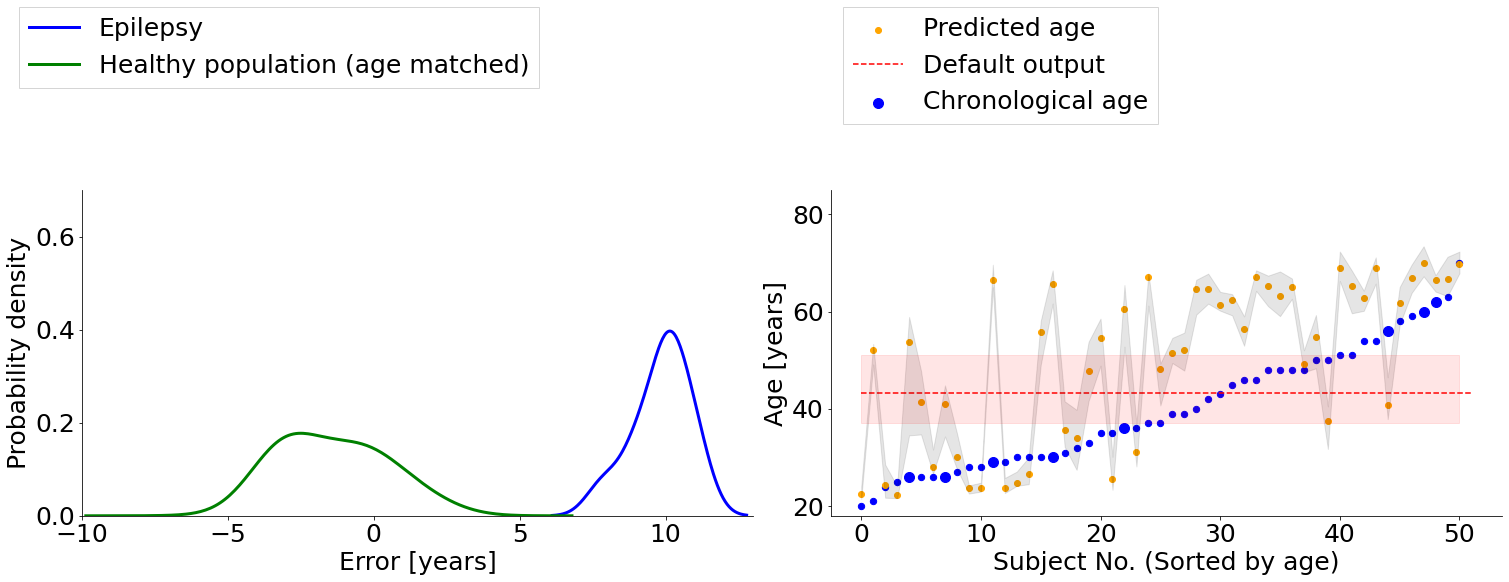

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
idx = np.argsort(y_epilepsy_sub_test)

ss = np.linspace(-0.0, len(idx) - 1, len(idx))

ax[1].scatter(np.arange(len(idx))[all_study_type[idx] == 1], y_epilepsy_sub_test[idx][all_study_type[idx] == 1], s=100, marker='o', c='blue', label='Chronological age')
ax[1].scatter(np.arange(len(idx))[all_study_type[idx] == 2], y_epilepsy_sub_test[idx][all_study_type[idx] == 2], s=40, marker='o', c='blue')
ax[1].fill_between(ss, min_s[idx], max_s[idx], color='k', alpha=0.1, zorder=3)
ax[1].scatter(np.arange(len(idx)), med_s[idx], marker='o', c='orange', label='Predicted age')

ax[1].set_xlabel('Subject No. (Sorted by age)')
ax[1].set_ylabel('Age [years]')
# ax[1].plot([0, 40], [np.mean(ages), np.mean(ages)], 'k--', alpha=1.0, label='Mean age (healthy training set)')
ax[1].plot([0, len(idx)], [np.mean(all_pred_zeros), np.mean(all_pred_zeros)], 'r--', alpha=1.0, label='Default output')
ax[1].fill_between(ss, np.percentile(all_pred_zeros, 2.5), np.percentile(all_pred_zeros, 97.5), color='r', alpha=0.1, zorder=3)

handles, labels = ax[1].get_legend_handles_labels()
order = [1, 2, 0]
ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[0.0, 1.6])

ax[1].grid(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylim([18, 85])

X = np.array([np.median(a - y_epilepsy_sub_test) for a in all_pred_epilepsy_ages])
# X = list(itertools.chain.from_iterable([a - y_stroke_sub_test for a in all_pred_stroke_ages]))
# ax[0].hist(X)
sns.kdeplot(X, ax=ax[0], bw_method=.6, linewidth=3, label='Epilepsy', color='blue')
Y = [np.median(a - b) for a, b in zip(subsets_true, subsets_pred)]
# Y = list(itertools.chain.from_iterable([a - b for a, b in zip(subsets_true, subsets_pred)]))
sns.kdeplot(Y, ax=ax[0], bw_method=.6, linewidth=3, label='Healthy population (age matched)', color='g')
# ax[0].hist(Y, color='g')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend(shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[.7, 1.6])
ax[0].set_xlabel("Error [years]")
ax[0].set_ylabel("Probability density")
ax[0].grid(False)
ax[0].set_xlim([-10, 13])
ax[0].set_ylim([0, 0.7])

plt.tight_layout()

plt.savefig('./figures/v18/figure_2_panel_d_epilepsy.pdf')

In [51]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(X, Y)

df_fig2_epi = pd.DataFrame({'type': ['epi distro', 'healthy distro', 't-test'], 
                        'p-val': [np.nan, np.nan, pval],
                        't-val': [np.nan, np.nan, tval], 
                        '25th': [np.percentile(X, 25),np.percentile(Y, 25), np.nan],
                        '50th': [np.percentile(X, 50),np.percentile(Y, 50), np.nan],
                        '75th': [np.percentile(X, 75),np.percentile(Y, 75), np.nan],
                         'mean': [np.mean(X),np.mean(Y), np.nan],
                            'MAE': [np.mean(np.abs(y_epilepsy_sub_test - med_s)),np.nan, np.nan]
                           })
df_fig2_epi.to_csv('./figures/v18/fig2_epi_stats_2.csv')
df_fig2_epi



,type,p-val,t-val,25th,50th,75th,mean,MAE
0,epi distro,NaN,NaN,9.327887,10.056175,10.296015,9.845620,12.80277
1,healthy distro,NaN,NaN,-2.865915,-1.720612,-0.167389,-1.426603,NaN
2,t-test,3.165663e-90,20.348336,NaN,NaN,NaN,NaN,NaN


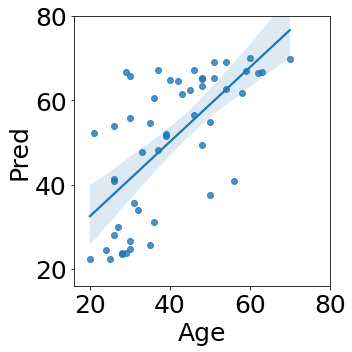

In [55]:
df_ = pd.DataFrame({'Age': y_epilepsy_sub_test[idx], 'Pred' : med_s[idx]})
fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.regplot(y="Pred", x="Age", data=df_);
ax.set_xlabel('Age')
ax.set_ylabel('Pred');
ax.set_xlim([16, 80])
ax.set_ylim([16, 80])
ax.set_xticks([20, 40, 60, 80])
plt.tight_layout()
plt.grid(False)
plt.savefig('./figures/v18/figure_2_insert_epilepsy_v2.pdf')
savemat('./data/figure_2_xgboost_insert_epi.mat', {'real_epi': y_epilepsy_sub_test[idx], 'pred_epi': med_s[idx]})

# Explain 

## Accelerated aging epi

In [365]:
all_pred_epi_ages = [a.predict(X_e_df) for a in all_models]
all_pred_rns_ages = [a.predict(X_r_df) for a in all_models]

In [366]:
X_epi_df = pd.concat([X_r_df, X_e_df], axis=0).reset_index(drop=True)

In [367]:
acc_ag_epi = np.where(y_epilepsy_sub_test < med_s)[0]
acc_ag_epi

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 24, 25, 26, 27, 28, 30, 31, 34, 35, 37, 38, 39, 40, 42,
       44, 45, 46, 48, 49, 50])

In [368]:
explainer = shap.Explainer(all_models[0])
epi_shap = explainer(X_epi_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [369]:
all_shap_epi = epi_shap[acc_ag_epi]

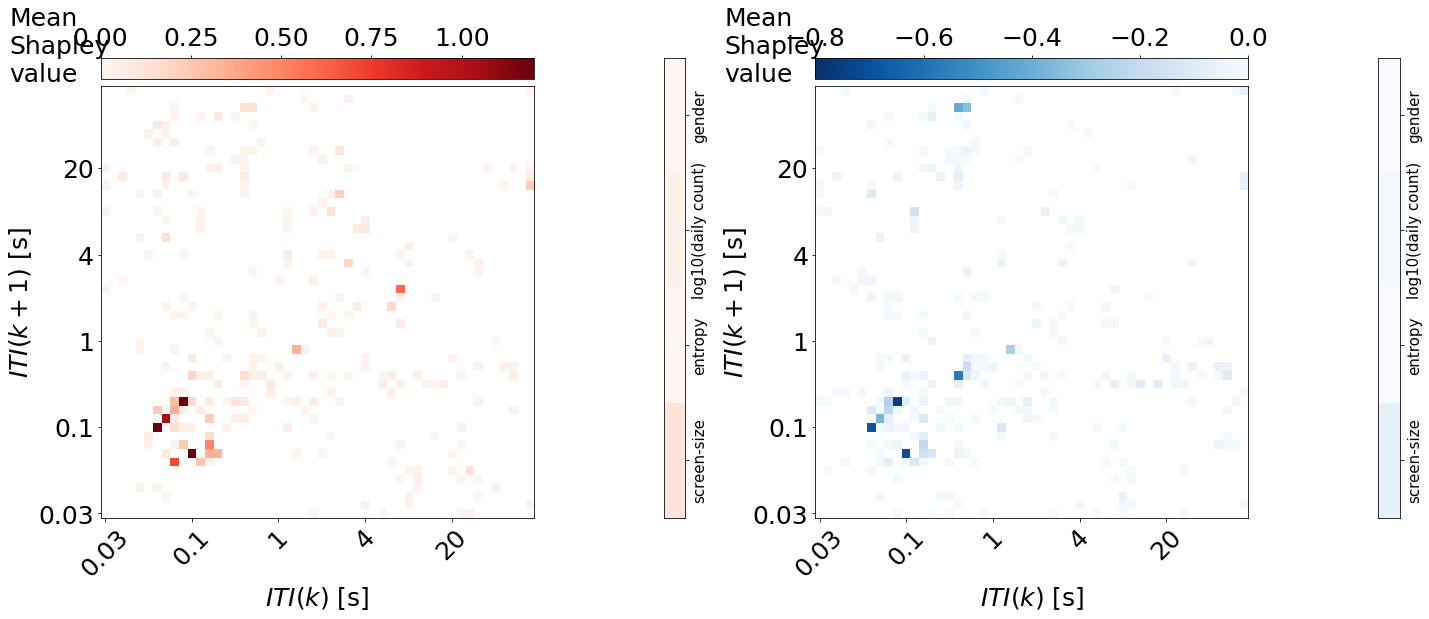

In [384]:
fig = plt.figure(figsize=(20, 8.7))
gs0 = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 0.05, 1, 0.05])

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

shap_values = all_shap_epi
pos_val = np.zeros((len(shap_values), 50, 50)) * np.nan
neg_val = np.zeros((len(shap_values), 50, 50)) * np.nan
pos_extra = np.zeros((len(shap_values), 4)) * np.nan
neg_extra = np.zeros((len(shap_values), 4)) * np.nan
for IDX in range(len(shap_values)):
    _pos = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _neg = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _pos_e = copy.deepcopy(shap_values[IDX].values[2500:])
    _neg_e = copy.deepcopy(shap_values[IDX].values[2500:])
    
    _pos[_pos < 0] = 0
    pos_val[IDX] = _pos
    _pos_e[_pos_e < 0] = 0
    pos_extra[IDX] = _pos_e
    
    _neg[_neg > 0] = 0
    neg_val[IDX] = _neg
    _neg_e[_neg_e > 0] = 0
    neg_extra[IDX] = _neg_e

    
m_pos = np.nanmean(pos_val, 0)
mask = np.ones_like(m_pos)
mask[m_pos < 0.01] = np.nan
ax0 = fig.add_subplot(gs0[0, 0])
im = ax0.imshow(m_pos * mask, cmap='Reds', vmax=1.2, vmin=0, aspect='auto')
ax0.invert_yaxis()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels)
ax0.xaxis.set_tick_params(rotation=45)
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)
ax0.set_ylabel(r'$ITI(k + 1)$ [s]')
ax0.set_xlabel(r'$ITI(k)$ [s]')
ax0.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)
    
    
ax01 = fig.add_subplot(gs0[0, 1])
ax01.imshow(np.nanmean(pos_extra, 0)[:, None], vmax=1.2, vmin=0, cmap='Reds', aspect='auto')
ax01.yaxis.tick_right()
ax01.set_xticks([])
ax01.set_yticks([0, 1, 2, 3])
ax01.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90, size=15, verticalalignment='center')

# ax99 = fig.add_subplot(gs0[0, 2])
# ax99.set_xticks([])
# ax99.set_yticks([])
# ax99.spines['right'].set_visible(False)
# ax99.spines['top'].set_visible(False)
# ax99.spines['left'].set_visible(False)
# ax99.spines['bottom'].set_visible(False)

m_neg = np.nanmean(neg_val, 0)
mask = np.ones_like(m_neg)
mask[m_neg > -0.01] = np.nan
ax1 = fig.add_subplot(gs0[0, 2])
im = ax1.imshow(m_neg * mask, cmap="Blues_r", vmin=-.8, vmax=0, aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax1.invert_yaxis()
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_yticks(ticks)
ax1.set_yticklabels(labels)
ax1.set_ylabel(r'$ITI(k + 1)$ [s]')
ax1.set_xlabel(r'$ITI(k)$ [s]')
ax1.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)

ax11 = fig.add_subplot(gs0[0, 3])
ax11.imshow(np.nanmean(neg_extra, 0)[:, None], vmin=-0.8, vmax=0, cmap='Blues_r', aspect='auto')
ax11.yaxis.tick_right()
ax11.set_xticks([])
ax11.set_yticks([0, 1, 2, 3])
ax11.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90, size=15, verticalalignment='center')

plt.tight_layout()
plt.savefig("figures/v18/accelerated_aging_epi.pdf")

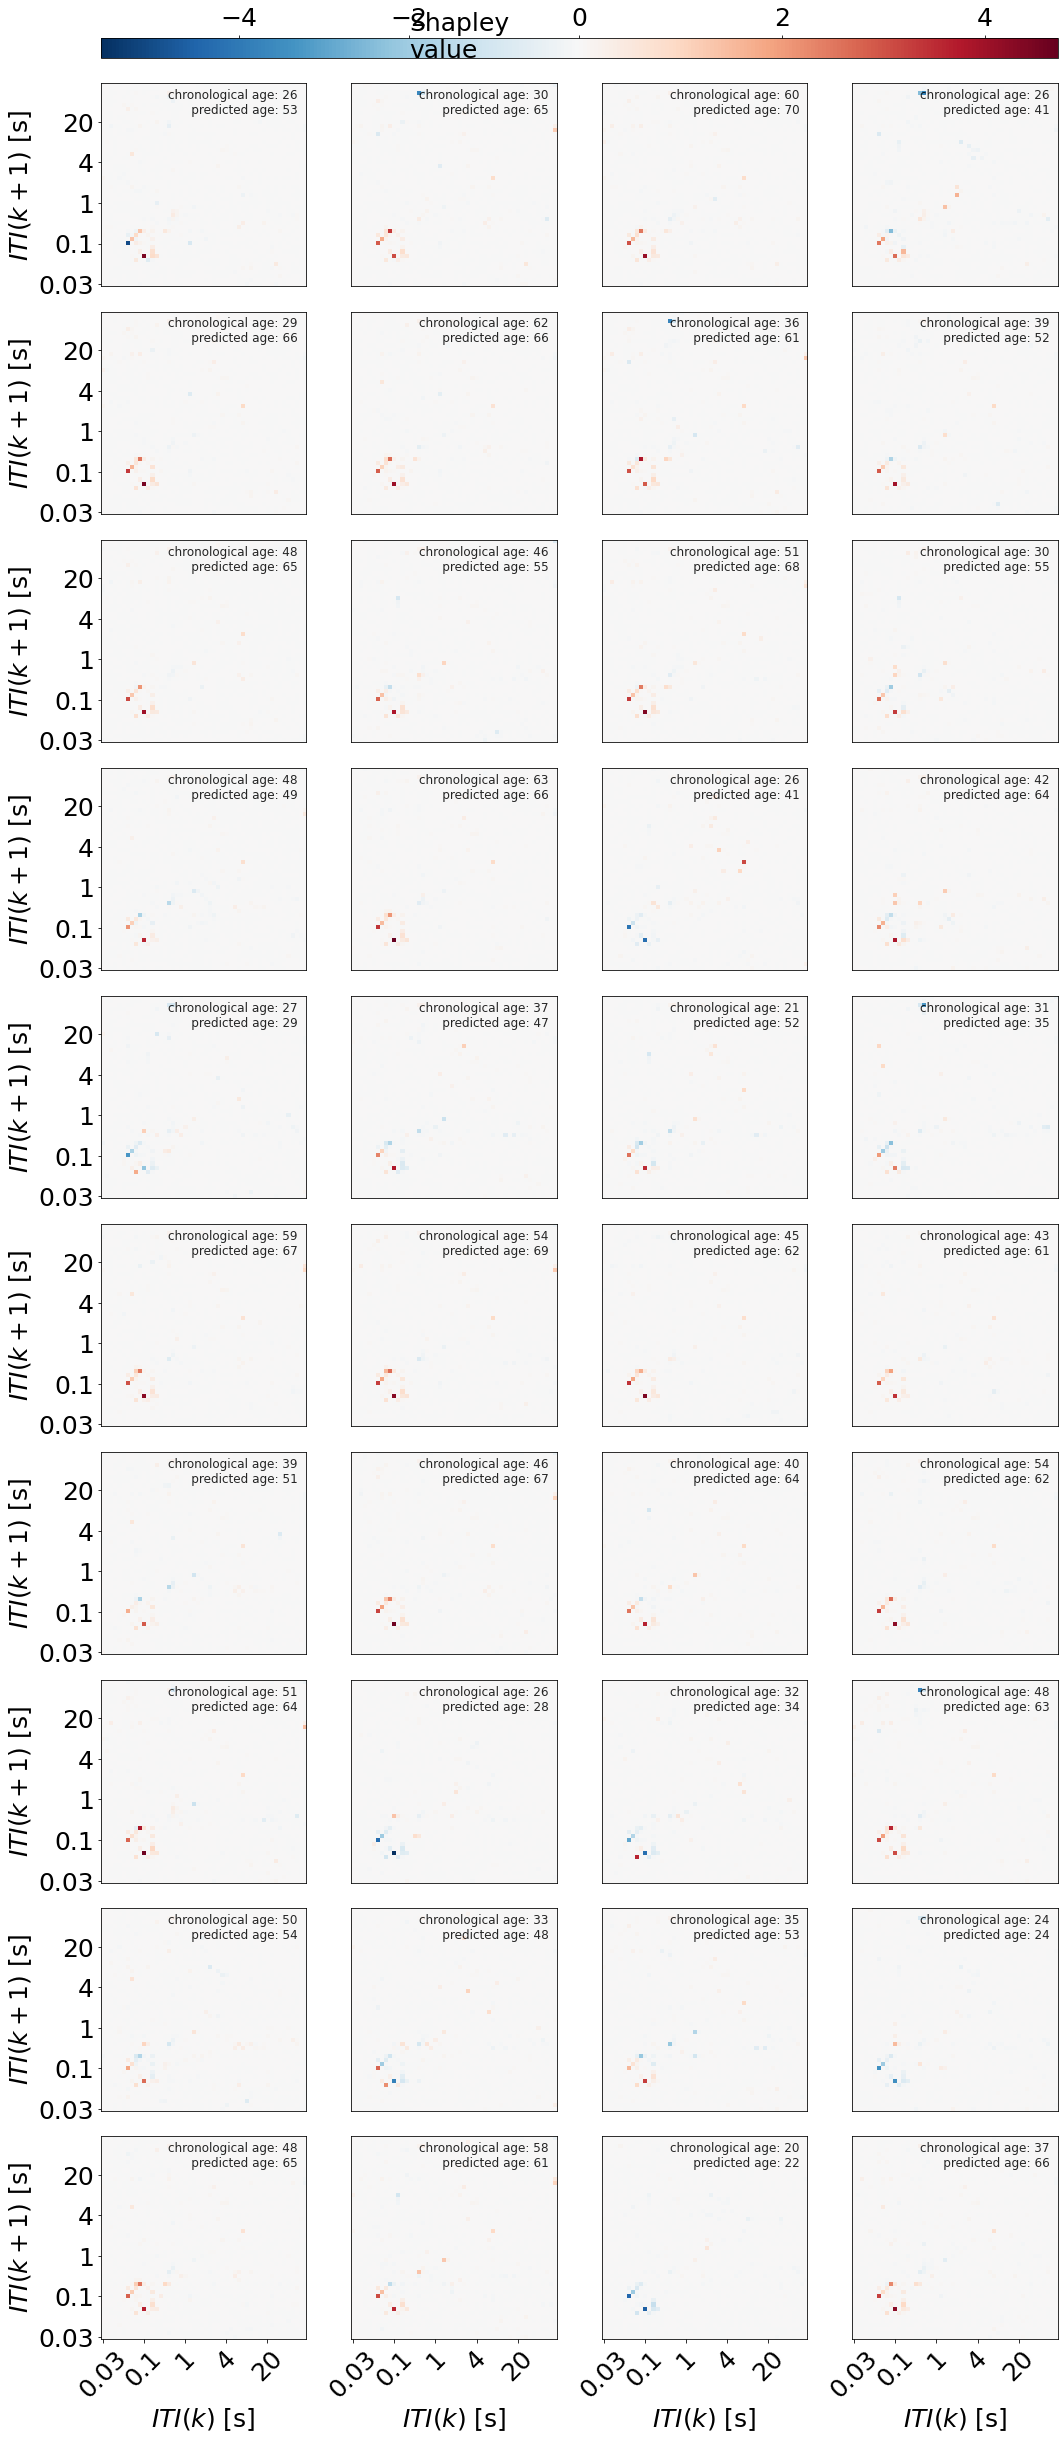

In [371]:
vmin = np.min(np.array([a.values for a in all_shap_epi]))
vmax = np.max(np.array([a.values for a in all_shap_epi]))

shap_values = all_shap_epi
fig = plt.figure(figsize=(15, 34))
main_grid = gridspec.GridSpec(11, 4,  figure=fig, height_ratios=[0.1] + [1] * 10)
cax = fig.add_subplot(main_grid[0, :])

for i, idx in enumerate(acc_ag_epi):
    ax = fig.add_subplot(main_grid[i // 4 + 1, i % 4])
    aa = np.reshape(shap_values[i].values[:2500], (50, 50))
#     aa[np.abs(aa)<1e-3] = 0
    im = ax.imshow(aa, norm=colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), aspect='auto', cmap='RdBu_r')
    labels = ['0.03', '0.1', '1', '4', '20']
    ticks = np.arange(50)[::10]

#     divider = make_axes_locatable(ax)
#     cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
#     fig.add_axes(cax)
#     cb = fig.colorbar(im, cax=cax, orientation="horizontal")
#     cb.ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    
    if (i % 4) == 0:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.set_ylabel(r'$ITI(k + 1)$ [s]')
    else:
        ax.set_yticks([])
    if (i // 4) == 9:
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_xlabel(r'$ITI(k)$ [s]')
    else:
        ax.set_xticks([])
    
    ax.text(16,42,f"chronological age: { y_epilepsy_sub_test[idx]}\n      predicted age: {int(med_s[idx])}", size=12, alpha=0.85)
    
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
cax.text(-2, 0, 'Shapley\nvalue', size=25)
plt.tight_layout()
plt.savefig('figures/v18/accelerated_aging_full_epi.pdf')

## Accelerated aging stroke

In [403]:
all_pred_str_ages = [a.predict(X_s_df) for a in all_models]
acc_ag_str = np.where(y_stroke_sub_test < med_s_stroke)[0]
acc_ag_str

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 13, 16, 17, 19, 20, 21, 22,
       23, 25, 26, 29, 32, 33, 34, 37, 38, 39, 40])

In [404]:
explainer_str = shap.Explainer(all_models[0])
str_shap = explainer_str(X_s_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [405]:
all_shap_str = str_shap[acc_ag_str]

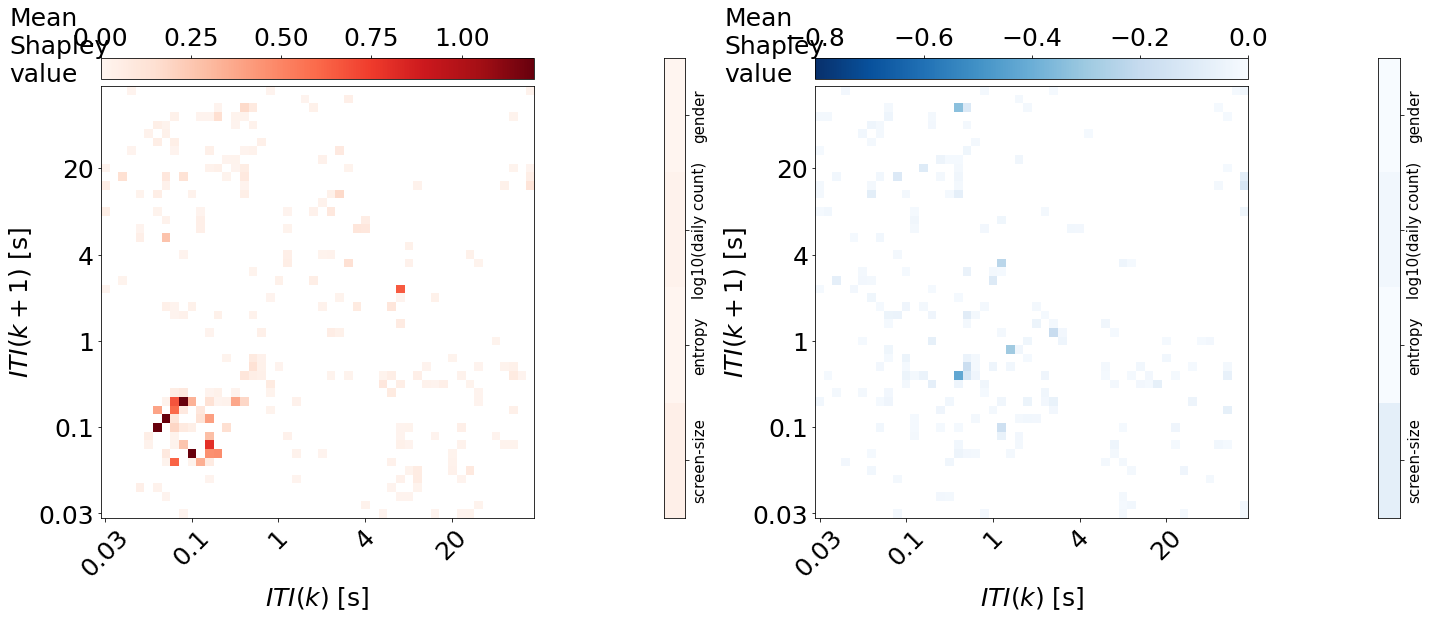

In [409]:
fig = plt.figure(figsize=(20, 8.7))
gs0 = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 0.05, 1, 0.05])

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

shap_values = all_shap_str
pos_val = np.zeros((len(shap_values), 50, 50)) * np.nan
neg_val = np.zeros((len(shap_values), 50, 50)) * np.nan
pos_extra = np.zeros((len(shap_values), 4)) * np.nan
neg_extra = np.zeros((len(shap_values), 4)) * np.nan
for IDX in range(len(shap_values)):
    _pos = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _neg = copy.deepcopy(np.reshape(shap_values[IDX].values[:2500], (50, 50)))
    _pos_e = copy.deepcopy(shap_values[IDX].values[2500:])
    _neg_e = copy.deepcopy(shap_values[IDX].values[2500:])
    
    _pos[_pos < 0] = 0
    pos_val[IDX] = _pos
    _pos_e[_pos_e < 0] = 0
    pos_extra[IDX] = _pos_e
    
    _neg[_neg > 0] = 0
    neg_val[IDX] = _neg
    _neg_e[_neg_e > 0] = 0
    neg_extra[IDX] = _neg_e

    
m_pos = np.nanmean(pos_val, 0)
mask = np.ones_like(m_pos)
mask[m_pos < 0.01] = np.nan
ax0 = fig.add_subplot(gs0[0, 0])
im = ax0.imshow(m_pos * mask, cmap='Reds', vmax=1.2, vmin=0, aspect='auto')
ax0.invert_yaxis()
divider = make_axes_locatable(ax0)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels)
ax0.xaxis.set_tick_params(rotation=45)
ax0.set_yticks(ticks)
ax0.set_yticklabels(labels)
ax0.set_ylabel(r'$ITI(k + 1)$ [s]')
ax0.set_xlabel(r'$ITI(k)$ [s]')
ax0.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)
    
    
ax01 = fig.add_subplot(gs0[0, 1])
ax01.imshow(np.nanmean(pos_extra, 0)[:, None], vmax=1.2, vmin=0, cmap='Reds', aspect='auto')
ax01.yaxis.tick_right()
ax01.set_xticks([])
ax01.set_yticks([0, 1, 2, 3])
ax01.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90,size=15, verticalalignment='center')

# ax99 = fig.add_subplot(gs0[0, 2])
# ax99.set_xticks([])
# ax99.set_yticks([])
# ax99.spines['right'].set_visible(False)
# ax99.spines['top'].set_visible(False)
# ax99.spines['left'].set_visible(False)
# ax99.spines['bottom'].set_visible(False)

m_neg = np.nanmean(neg_val, 0)
mask = np.ones_like(m_neg)
mask[m_neg > -0.01] = np.nan
ax1 = fig.add_subplot(gs0[0, 2])
im = ax1.imshow(m_neg * mask, cmap="Blues_r", vmin=-0.8, vmax=0, aspect='auto')
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
ax1.invert_yaxis()
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=45)
ax1.set_yticks(ticks)
ax1.set_yticklabels(labels)
ax1.set_ylabel(r'$ITI(k + 1)$ [s]')
ax1.set_xlabel(r'$ITI(k)$ [s]')
ax1.text(-11, 50.1, 'Mean\nShapley\nvalue', size=25)

ax11 = fig.add_subplot(gs0[0, 3])
ax11.imshow(np.nanmean(neg_extra, 0)[:, None], vmin=-0.8, vmax=0, cmap='Blues_r', aspect='auto')
ax11.yaxis.tick_right()
ax11.set_xticks([])
ax11.set_yticks([0, 1, 2, 3])
ax11.set_yticklabels([new_names[2500], new_names[2501], new_names[2502], new_names[2503]], rotation=90, size=15, verticalalignment='center')

plt.tight_layout()
plt.savefig("figures/v18/accelerated_aging_stroke.pdf")

In [407]:
acc_ag_str.shape

(28,)

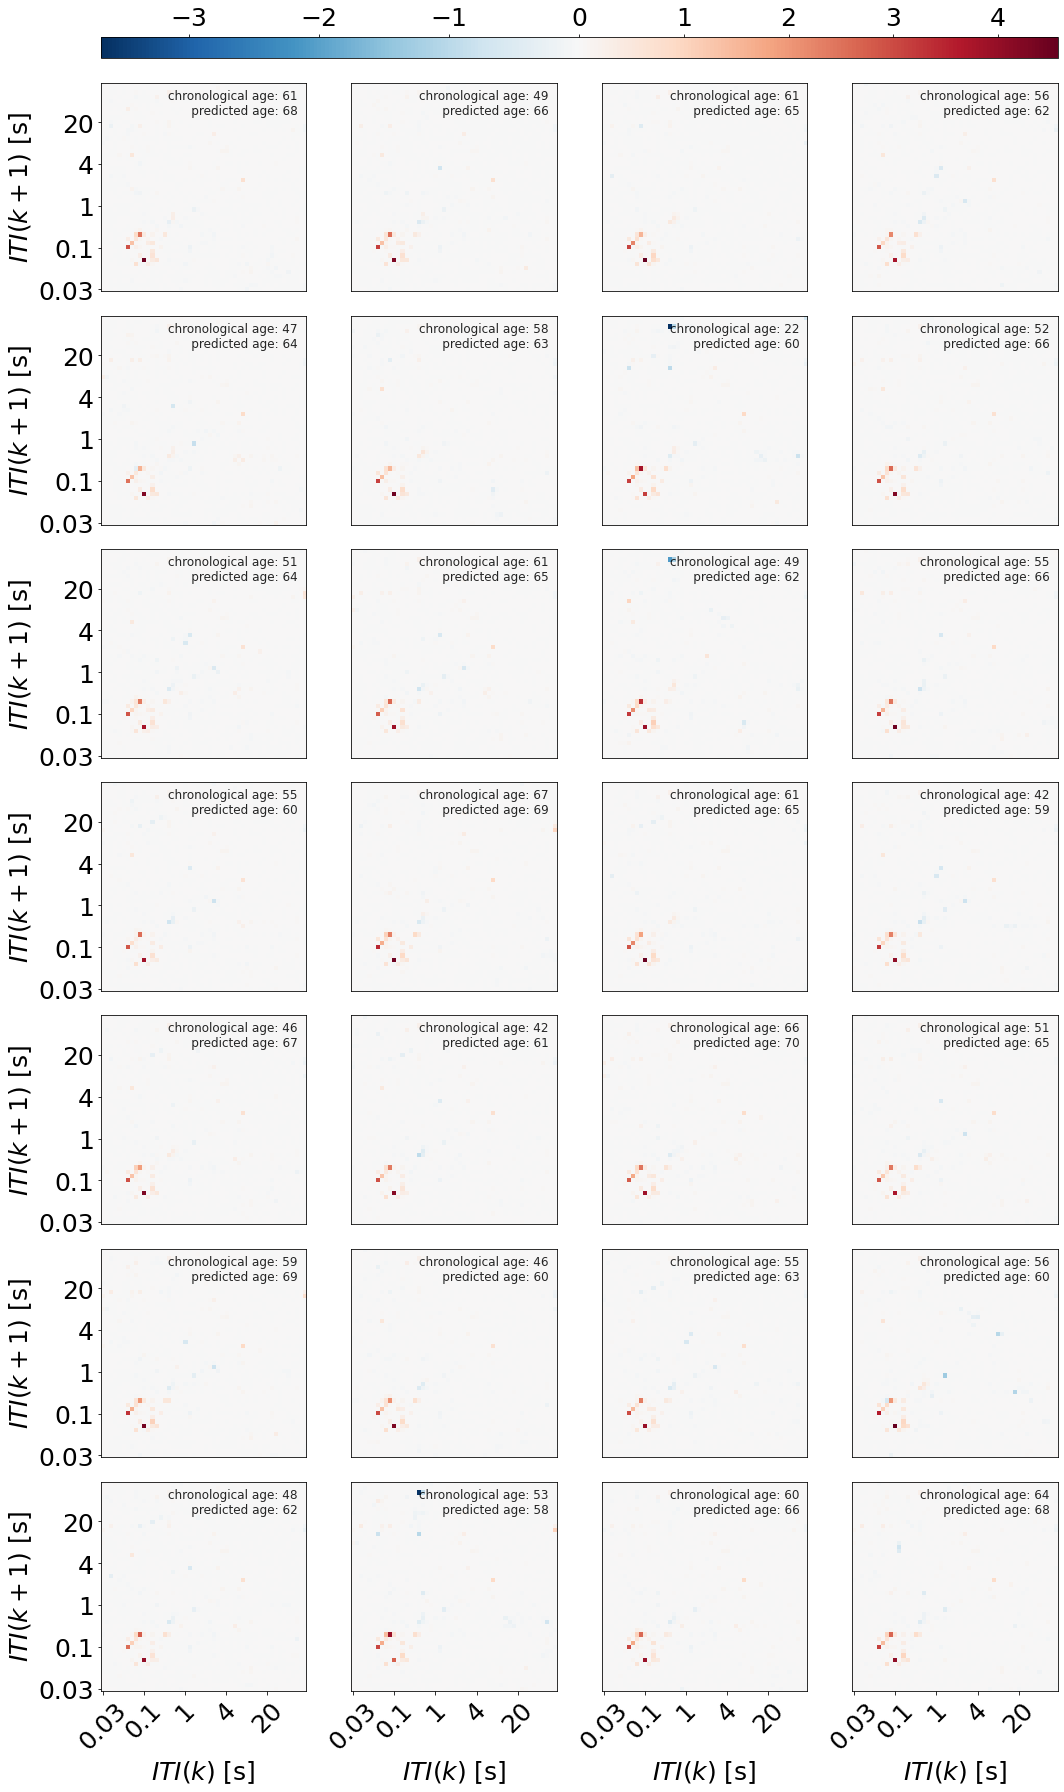

In [408]:
vmin = np.min(np.array([a.values for a in all_shap_str]))
vmax = np.max(np.array([a.values for a in all_shap_str]))

shap_values = all_shap_str
fig = plt.figure(figsize=(15, 25))

main_grid = gridspec.GridSpec(8, 4,  figure=fig, height_ratios=[0.1] + [1] * 7)
cax = fig.add_subplot(main_grid[0, :])

for i, idx in enumerate(acc_ag_str[:28]):
    ax = fig.add_subplot(main_grid[i // 4 + 1, i % 4])
    aa = np.reshape(shap_values[i].values[:2500], (50, 50))
#     aa[np.abs(aa)<1e-3] = 0
    im = ax.imshow(aa, norm=colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), aspect='auto', cmap='RdBu_r')
    labels = ['0.03', '0.1', '1', '4', '20']
    ticks = np.arange(50)[::10]

#     divider = make_axes_locatable(ax)
#     cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
#     fig.add_axes(cax)
#     cb = fig.colorbar(im, cax=cax, orientation="horizontal")
#     cb.ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    
    if (i % 4) == 0:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.set_ylabel(r'$ITI(k + 1)$ [s]')
    else:
        ax.set_yticks([])
        
    if (i // 4) == 6:
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_xlabel(r'$ITI(k)$ [s]')
    else:
        ax.set_xticks([])
    
    ax.text(16,42,f"chronological age: { y_stroke_sub_test[idx]}\n      predicted age: {int(med_s_stroke[idx])}", size=12, alpha=0.85)

cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

plt.tight_layout()
plt.savefig('figures/v18/accelerated_aging_full_stroke.pdf')

# Supplementary 1

In [470]:
e_to_add = []
for e in e_sp:
    if len(e[0][0][0]) > 0:
        e_to_add.append(e[0][0][0][0])
    else:
        e_to_add.append(np.nan)
e_to_add = np.array(e_to_add)

In [471]:
more_info = pd.read_csv('./csvs/more_info_for_review_v18.csv')
more_info.insert(1, "entropy", e_to_add)
more_info = more_info[more_info.age > 0]
more_info = more_info[more_info.n_taps > 100]
more_info = more_info[more_info.n_days > 7]
more_info.head()

,partId,entropy,psyId,n_taps,age,gender,n_days,usage,phoneModel,n_apps,fingerdness(1),fingerdness(2),yearsused,pcs,mcs
0,138ee6d165fa06954ba1bed56719415b12dd28eb,8.542300,aaaaaaeF,5449072,61,2,679,7621.0,6.4,199,1.0,0.625,10.0,86.745453,85.421424
1,138ee5b320ea6ee948d2a3bf2f8c55ffecd428eb,8.554025,aaaaaaeI,339201,23,2,149,12080.0,5.8,88,-1.0,-1.000,-1.0,-1.000000,-1.000000
2,138ee5990d0a29304d079d1d96be414edbd528eb,9.112261,aaaaaaeJ,9978,38,2,8,144.0,6.4,40,-1.0,-1.000,-1.0,65.269843,46.460806
3,138efc29c56fa8b346a18aab7b0dd3ae6fe928eb,8.665647,aaaaaacg,2348656,30,2,737,4000.0,5.9,191,NaN,NaN,NaN,-1.000000,-1.000000
4,138efcb63deffab44fc78f585ea98885759128eb,8.763527,aaaaaacb,19612,82,999,139,116.0,5.0,37,-1.0,-1.000,-1.0,73.145560,68.842544


In [472]:
len(more_info)

684

In [473]:
# need to put NaN where info is missing
more_info.phoneModel.replace(0, np.nan, inplace=True)
more_info.n_apps.replace([0, 1], np.nan, inplace=True)
more_info['fingerdness(1)'].replace(-1, np.nan, inplace=True)
more_info['fingerdness(2)'].replace(-1, np.nan, inplace=True)
more_info.yearsused.replace(-1, np.nan, inplace=True)
more_info.mcs.replace(-1, np.nan, inplace=True)
more_info.pcs.replace(-1, np.nan, inplace=True)
more_info.tail(20)

,partId,entropy,psyId,n_taps,age,gender,n_days,usage,phoneModel,n_apps,fingerdness(1),fingerdness(2),yearsused,pcs,mcs
699,138e19c51c6387874be2a6f20fe241cb6aaf28eb,9.156987,NaN,612564,23,1,118,3502.5,5.20,74.0,NaN,NaN,NaN,NaN,NaN
700,138e15979ed4070846a9a130779058b6729428eb,9.062863,NaN,403280,23,1,84,4222.0,6.18,61.0,NaN,NaN,NaN,NaN,NaN
701,138e13f513f180df4e39bda846e88028ad5928eb,8.594145,NaN,52579,27,2,36,1175.5,5.20,53.0,NaN,NaN,NaN,NaN,NaN
702,138e122d8474936c4382bed07df2c733000c28eb,8.843911,NaN,166711,23,2,27,5517.0,5.00,68.0,NaN,NaN,NaN,NaN,NaN
703,138e0faf005d745b4dd888c4a3705f54d59328eb,9.068715,NaN,204541,21,2,26,7864.5,5.80,89.0,NaN,NaN,NaN,NaN,NaN
704,138e0ef7b830428d4ee3a55715cfd8ecaf5428eb,8.990297,NaN,130437,22,2,23,5669.0,5.50,105.0,NaN,NaN,NaN,NaN,NaN
705,138e0e1f67662ff94edebf153703598a07ab28eb,9.049374,NaN,79690,26,1,43,2247.0,5.80,70.0,NaN,NaN,NaN,NaN,NaN
706,138e0de3cd59a03a4bc1b06bda8564023c5f28eb,8.918915,NaN,1143256,23,1,216,5266.5,5.50,105.0,NaN,NaN,NaN,NaN,NaN
707,138e0caedcd983c046cb8a88ab61c2811fda28eb,8.847378,NaN,533348,26,2,215,2436.5,5.65,147.0,NaN,NaN,NaN,NaN,NaN
708,138e0bef23ea39e84e77ae6f27263bae5a0928eb,9.036645,NaN,119667,25,1,34,3202.0,6.70,100.0,NaN,NaN,NaN,NaN,NaN


In [474]:
info_m = more_info[more_info.gender == 1]
info_f = more_info[more_info.gender == 2]

info_m = info_m.sort_values('age')
info_f = info_f.sort_values('age')
len(info_m), len(info_f)
info_m.head()

,partId,entropy,psyId,n_taps,age,gender,n_days,usage,phoneModel,n_apps,fingerdness(1),fingerdness(2),yearsused,pcs,mcs
651,138e6253ef27ed5544fea626398f2389ef0428eb,8.897122,NaN,187025,17,1,164,1047.0,5.0,282.0,NaN,NaN,NaN,NaN,NaN
643,138e6676cb54fd3547bfa0e7b03d5a1f1f2228eb,8.797775,NaN,78687,17,1,149,5049.5,5.1,135.0,NaN,NaN,NaN,NaN,NaN
680,138e391198df740a48bfb0e167884b51486428eb,8.913114,NaN,150124,18,1,47,7270.0,6.2,91.0,NaN,NaN,NaN,NaN,NaN
633,138e7080a5ddc5624b4b92f9d424bca8ea1728eb,9.035533,NaN,412031,18,1,121,3723.0,5.5,125.0,NaN,NaN,NaN,NaN,NaN
635,138e6fd51c5df3334509a4d762976234b46128eb,8.684811,NaN,209511,19,1,72,6438.5,5.5,117.0,NaN,NaN,NaN,NaN,NaN


In [475]:
len(info_m), len(info_f)

(247, 426)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


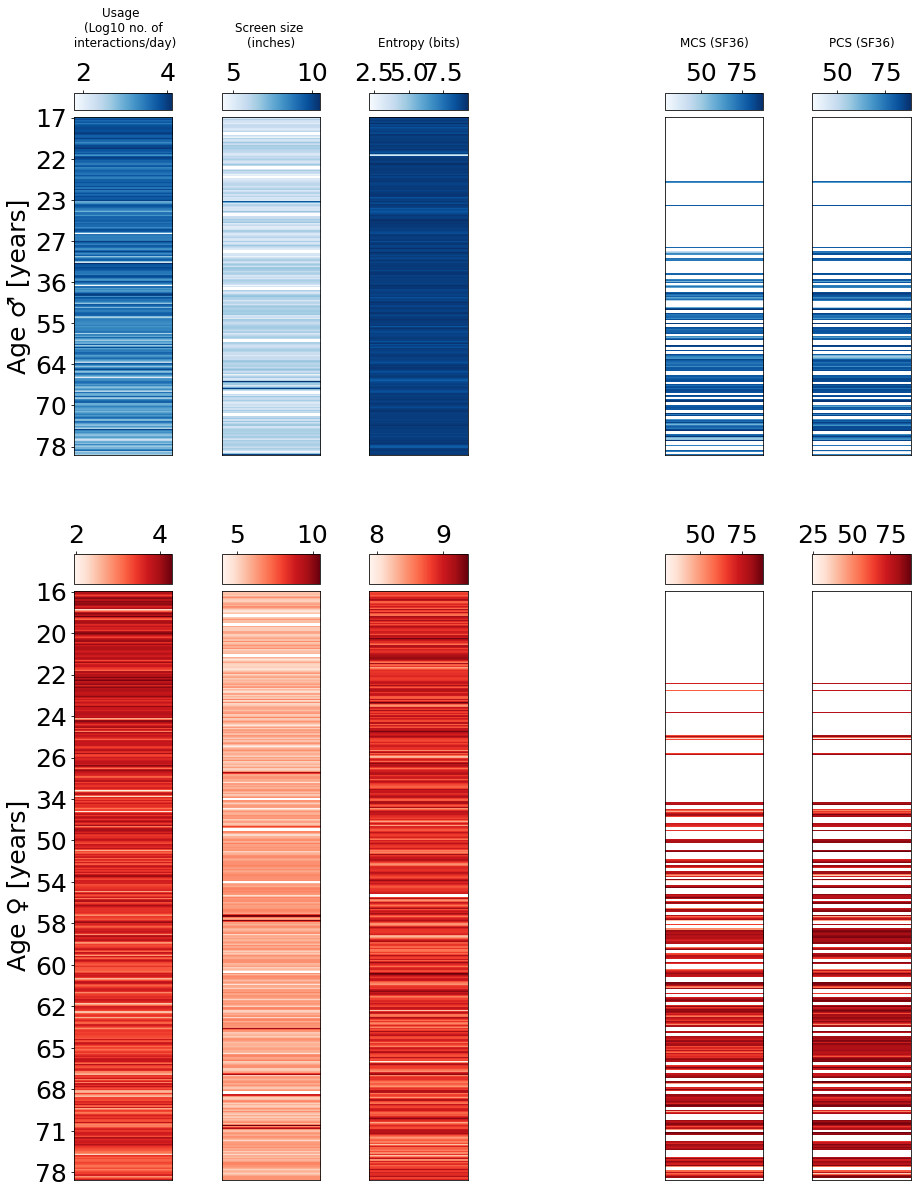

In [476]:
fig = plt.figure(figsize=(15, 20))
gs0 = gridspec.GridSpec(2, 6, figure=fig, height_ratios=[len(info_m) / len(info_f), 1], wspace=0.5)

# male
cmap = "Blues"
ax = [fig.add_subplot(gs0[0, i]) for i in range(6)]
im0 = ax[0].imshow(np.log10(info_m['usage']).values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im1 = ax[1].imshow(info_m['phoneModel'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im2 = ax[2].imshow(info_m['entropy'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im4 = ax[4].imshow(info_m['mcs'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im5 = ax[5].imshow(info_m['pcs'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
for _ax, _im, _cb_r, _title in zip([ax[0], ax[1], ax[2], ax[4], ax[5]], 
                    [im0, im1, im2, im4, im5], 
                    [[2, 4], [5, 10], [6, 9], [0, 85], [0, 85]], 
                    ["Usage \n(Log10 no. of\n interactions/day)", "Screen size \n(inches)", "Entropy (bits)", "MCS (SF36)", "PCS (SF36)"]):
    _ax.grid(0)
    _ax.set_xticks([])
    _ax.set_yticks([])
    divider = make_axes_locatable(_ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(_im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
#     cb.ax.xaxis.set_ticks(_cb_r)
    _ax.set_title(_title, pad=70, size=12)

ax[0].set_yticks(range(0, len(info_m), 30))
ax[0].set_yticklabels([info_m.age.values[i] for i in range(0, len(info_m), 30)])
ax[0].set_ylabel("Age \u2642 [years]")

    
for _ax in [ax[3]]:
    _ax.grid(0)
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.spines['right'].set_visible(False)
    _ax.spines['left'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.spines['bottom'].set_visible(False)

# female
ax = [fig.add_subplot(gs0[1, i]) for i in range(6)]
cmap = "Reds"
im0 = ax[0].imshow(np.log10(info_f['usage']).values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im1 = ax[1].imshow(info_f['phoneModel'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im2 = ax[2].imshow(info_f['entropy'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im4 = ax[4].imshow(info_f['mcs'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
im5 = ax[5].imshow(info_f['pcs'].values[:, None], aspect='auto', interpolation=None, cmap=cmap)
for _ax, _im, _cb_r in zip([ax[0], ax[1], ax[2], ax[4], ax[5]], 
                    [im0, im1, im2, im4, im5],
                    [[2, 4], [5, 10], [6, 9], [0, 85], [0, 85]]):
    _ax.grid(0)
    _ax.set_xticks([])
    _ax.set_yticks([])
    divider = make_axes_locatable(_ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(_im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
#     cb.ax.xaxis.set_ticks(_cb_r)
    
for _ax in [ax[3]]:
    _ax.grid(0)
    _ax.set_xticks([])
    _ax.set_yticks([])
    _ax.spines['right'].set_visible(False)
    _ax.spines['left'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    _ax.spines['bottom'].set_visible(False)

ax[0].set_yticks(range(0, len(info_f), 30))
ax[0].set_yticklabels([info_f.age.values[i] for i in range(0, len(info_f), 30)])
ax[0].set_ylabel("Age \u2640 [years]")
plt.tight_layout()
plt.savefig('figures/v18/figure_1_more_info_columns.pdf')